# <b>set dir

In [ ]:
import os
import pandas as pd

# 设置当前工作文件夹，并读取数据文件
os.chdir(r'\\your_file\\code')
current_directory = os.getcwd()
print("当前工作文件夹：", current_directory)

# 读取Excel文件中的政策文本数据
print("正在读取数据...")
df_policies = pd.read_excel('Policies_text.xlsx', sheet_name='Sheet1')

# 检查和清洗数据
print(f"数据总行数: {len(df_policies)}")
print(f"'content'列空值数量: {df_policies['content'].isna().sum()}")
df_policies = df_policies.dropna(subset=['content'])
print(f"清洗后数据行数: {len(df_policies)}")


当前工作文件夹： C:\bgy\C-documents\碧桂园\集团运营管理工作\专项工作\2023年保交楼\23-12-15\刘磊-监控资金政策分析\code
正在读取数据...
数据总行数: 41
'content'列空值数量: 0
清洗后数据行数: 41


# <b>Keywords coorrence network
Based on BERT

In [5]:
import os
import pandas as pd
import numpy as np
import jieba.analyse
import torch
from transformers import BertTokenizer, BertModel
from numpy import dot
from numpy.linalg import norm

# ==============================
# 1. 读取并清洗数据
# ==============================
# 已经在上一步读入了政策文本数据

# ==============================
# 2. 加载BERT模型及分词器（bert‑base‑Chinese）
# ==============================
print("加载 bert‑base‑Chinese 模型与分词器...")
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese')
model.eval()  # 设置为评估模式

# ==============================
# 3. 提取关键词
# ==============================
# 这里我们为每篇文本提取 top 5 个关键词（可根据需要调整topK值）
docs_keywords = []
all_keywords = set()

for content in df_policies['content']:
    # 提取关键词，返回列表
    keywords = jieba.analyse.extract_tags(content, topK=50)
    docs_keywords.append(keywords)
    all_keywords.update(keywords)

all_keywords = list(all_keywords)
print(f"共提取到 {len(all_keywords)} 个候选关键词")

# ==============================
# 4. 计算每个关键词的BERT嵌入
# ==============================
def get_embedding(text):
    # 对关键词进行编码，限制最大长度（一般关键词较短）
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=32)
    with torch.no_grad():
        outputs = model(**inputs)
    # 采用 [CLS] 向量作为关键词的表示
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

keyword_embeddings = {}
print("计算每个关键词的BERT嵌入...")
for kw in all_keywords:
    keyword_embeddings[kw] = get_embedding(kw)

# ==============================
# 5. 定义余弦相似度函数
# ==============================
def cosine_similarity(a, b):
    return dot(a, b) / (norm(a) * norm(b))

# ==============================
# 6. 构建关键词共现网络（邻接矩阵）
# ==============================
n = len(all_keywords)
adj_matrix = np.zeros((n, n))
kw_index = {kw: idx for idx, kw in enumerate(all_keywords)}

# 对每篇文档的关键词列表，统计每对关键词的共现
# 累加时，边权为该对关键词的余弦相似度
for keywords in docs_keywords:
    # 使用set去重，同一文档中关键词只计算一次
    keywords = list(set(keywords))
    for i in range(len(keywords)):
        for j in range(i+1, len(keywords)):
            kw_i = keywords[i]
            kw_j = keywords[j]
            sim = cosine_similarity(keyword_embeddings[kw_i], keyword_embeddings[kw_j])
            idx_i = kw_index[kw_i]
            idx_j = kw_index[kw_j]
            # 累加边权（共现计数中加入语义相似度权重）
            adj_matrix[idx_i, idx_j] += sim
            adj_matrix[idx_j, idx_i] += sim

# 转换为 DataFrame 显示邻接矩阵
adj_df = pd.DataFrame(adj_matrix, index=all_keywords, columns=all_keywords)
print("共现网络邻接矩阵：")
print(adj_df)


加载 bert‑base‑Chinese 模型与分词器...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Eric\AppData\Local\Temp\jieba.cache
Loading model cost 0.541 seconds.
Prefix dict has been built successfully.


共提取到 472 个候选关键词
计算每个关键词的BERT嵌入...
共现网络邻接矩阵：
          使用权  100        开户        确定       定安县   分项  10%         规定  管理局  \
使用权  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   1.741610  0.0   
100  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   0.822276  0.0   
开户   0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   0.000000  0.0   
确定   0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   1.788533  0.0   
定安县  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   0.800493  0.0   
..        ...  ...       ...       ...       ...  ...  ...        ...  ...   
部门   0.844894  0.0  0.835372  1.711015  0.824398  0.0  0.0  10.547677  0.0   
承购   0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   0.000000  0.0   
采购网  0.000000  0.0  0.000000  0.000000  0.794233  0.0  0.0   0.836500  0.0   
整治   0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   0.000000  0.0   
购置   0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   0.000000  0.0   

      乐东黎族自治县  ... 

C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\284231048.py:124: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos,


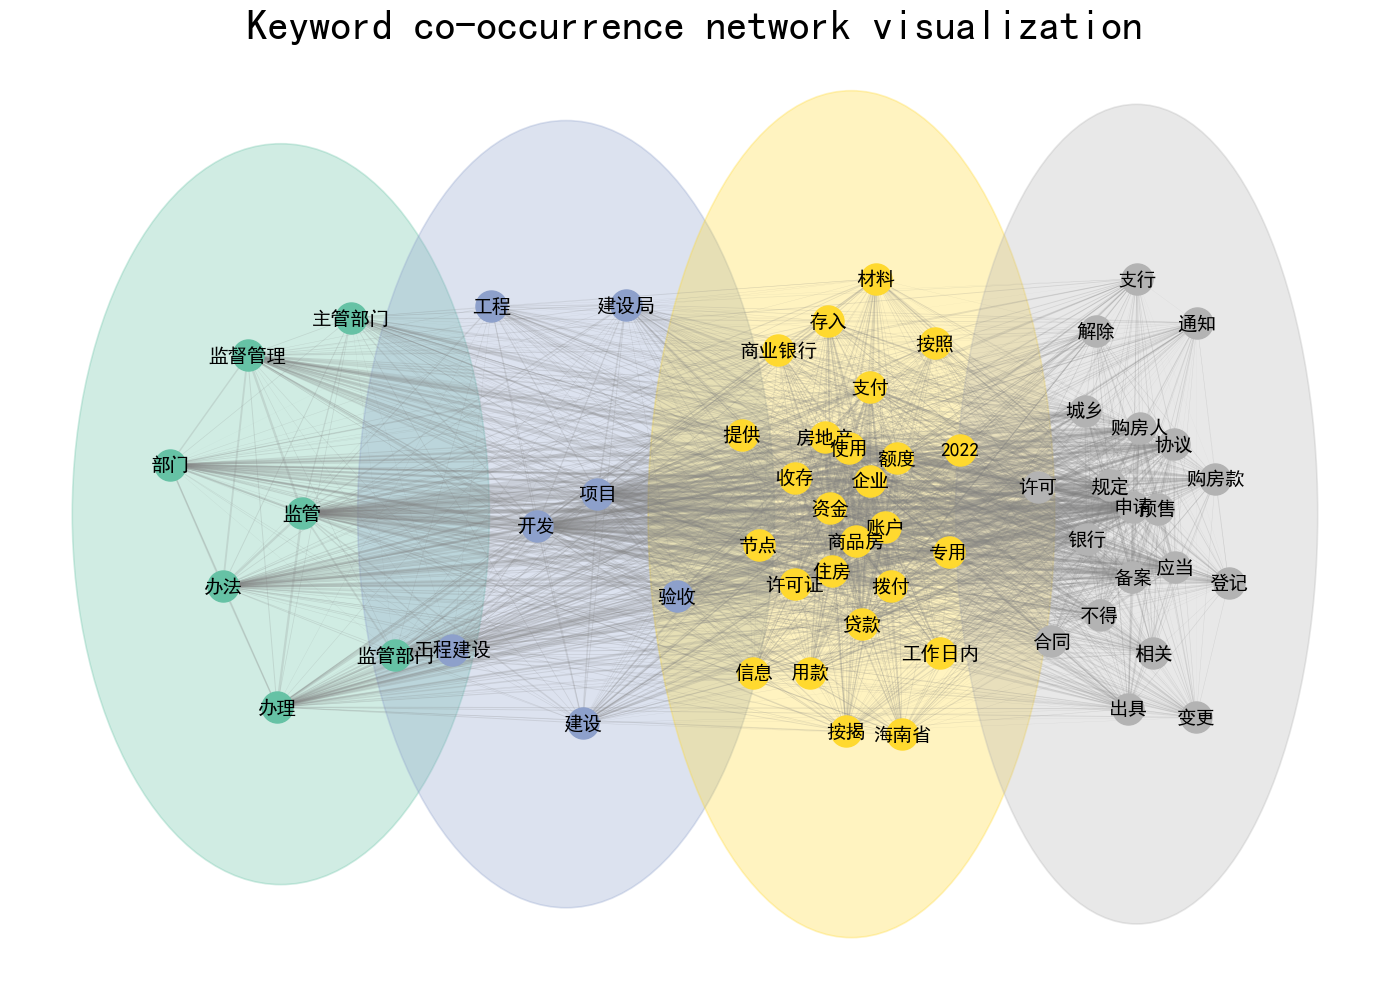

In [6]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib import colormaps
from matplotlib.patches import Ellipse

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 假设 keyword_embeddings 和 adj_df 已经在其他地方定义
# 如果没有定义，请确保在此之前定义或从文件中读取这些变量

# -----------------------------
# 1. 自动统计关键词频率
# -----------------------------
kw_freq_series = adj_df.sum(axis=1)
kw_counter = kw_freq_series.sort_values(ascending=False)

top_keywords = kw_counter.head(60).index.tolist()

# 2. 嵌入矩阵
embeddings_matrix = []
valid_keywords = []

for kw in top_keywords:
    if kw in keyword_embeddings:
        embeddings_matrix.append(keyword_embeddings[kw])
        valid_keywords.append(kw)
    else:
        print(f"⚠️ 缺少嵌入向量，跳过：{kw}")

embeddings_matrix = np.array(embeddings_matrix)

# 3. KMeans 聚类
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto').fit(embeddings_matrix)
labels = kmeans.labels_

# 构建颜色映射
colors = colormaps['Set2'].resampled(n_clusters)
node_colors = {kw: colors(labels[idx]) for idx, kw in enumerate(valid_keywords)}
label_dict = {kw: labels[idx] for idx, kw in enumerate(valid_keywords)}

# -----------------------------
# 4. 构建网络图
# -----------------------------
G = nx.Graph()
for kw in valid_keywords:
    G.add_node(kw, cluster=node_colors[kw], label=label_dict[kw])

adj_df_top = adj_df.loc[valid_keywords, valid_keywords]

for i, kw_i in enumerate(valid_keywords):
    for j, kw_j in enumerate(valid_keywords):
        if i < j:
            weight = adj_df_top.loc[kw_i, kw_j]
            if weight > 0:
                G.add_edge(kw_i, kw_j, weight=weight)

# -----------------------------
# 5. 聚类感知布局（簇内集中）
# -----------------------------
# 先按聚类分组节点
clusters = {i: [] for i in range(n_clusters)}
for node in G.nodes():
    clusters[G.nodes[node]['label']].append(node)

# 为每个簇创建子布局，再合并到总图上
pos = {}
x_offset = 0
for cluster_id, nodes in clusters.items():
    subgraph = G.subgraph(nodes)
    # 局部布局
    sub_pos = nx.spring_layout(subgraph, seed=cluster_id, k=0.8)
    # 添加偏移量，使每个簇分开
    for node in sub_pos:
        sub_pos[node][0] += x_offset
    # 合并进全图布局
    pos.update(sub_pos)
    x_offset += 2.5  # 簇之间横向间隔

# -----------------------------
# 6. 绘图（细边 + 中文 + 聚类感知布局）
# -----------------------------
plt.figure(figsize=(14, 10))
ax = plt.gca()

# === 颜色包围框（聚类色块填充） ===
for cluster_id, nodes in clusters.items():
    cluster_pos = np.array([pos[n] for n in nodes])
    x_center = np.mean(cluster_pos[:, 0])
    y_center = np.mean(cluster_pos[:, 1])
    x_span = cluster_pos[:, 0].max() - cluster_pos[:, 0].min()
    y_span = cluster_pos[:, 1].max() - cluster_pos[:, 1].min()
    width = x_span * 1.6 + 0.5
    height = y_span * 1.6 + 0.5

    # 用 cluster 色彩作为半透明背景色块
    ellipse = Ellipse((x_center, y_center), width, height,
                      edgecolor=colors(cluster_id),        # 边框色（可选）
                      facecolor=colors(cluster_id),        # 填充色
                      linewidth=1.2,
                      linestyle='solid',
                      alpha=0.3)                          # 透明度控制
    ax.add_patch(ellipse)

# === 节点 ===
for kw in G.nodes():
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[kw],
                           node_color=[G.nodes[kw]['cluster']],
                           node_size=500)

# === 标签 ===
nx.draw_networkx_labels(G, pos, font_family='SimHei', font_size=14, font_color='black',
                       font_weight='bold', verticalalignment='center',)

# === 边 ===
edges = G.edges(data=True)
for (u, v, d) in edges:
    w = d['weight']
    nx.draw_networkx_edges(G, pos,
                           edgelist=[(u, v)],
                           width=w * 0.1,  # 线宽
                           edge_color='gray',
                           alpha=0.2, 
                           connectionstyle='arc3,rad=0.2')

plt.title("Keyword co-occurrence network visualization", fontsize=30, fontweight='bold')
# plt.xlim(-3, 3)
plt.axis('off')
plt.tight_layout()
plt.show()


# <b>PMC-frequency

In [7]:
import re
import jieba

# 定义文本预处理函数，执行特殊字符清洗、中文分词和停用词过滤
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # 去除非中文字符
    text = re.sub(r'[^\u4e00-\u9fa5]', ' ', text)
    # 使用jieba进行中文分词
    words = jieba.cut(text)
    # 定义简单的停用词集合（实际应用时应加载完整的停用词表）
    stopwords = {'的', '了', '和', '是', '在', '以', '对', '等', '与', '中', '将', '为'}
    filtered_words = [word for word in words if word.strip() and word not in stopwords and len(word) > 1]
    return ' '.join(filtered_words)

# 应用预处理函数
print("正在进行文本预处理...")
df_policies['processed_text'] = df_policies['content'].apply(preprocess_text)

df_policies['processed_text'].head(10)


正在进行文本预处理...


0    万宁市 人民政府 办公室 关于 印发 万宁市 商品房 预售 资金 监管 实施细则 通知 各镇...
1    上海市 全额 监管 涉及 用途 支付 第三方 账户 政府 名下 公司 监管 项目 建设 发生...
2    上饶市 房地产 管理局 关于 进一步 加强 商品房 预售 管理工作 通知 颁布 单位 上饶市...
3    关于 征求 东方 商品房 预售 资金 监管 实施细则 征求意见 意见 公告 加强 商品房 预...
4    东莞市 住房 城乡 建设局 关于 进一步 加强 商品房 预售 使用 差异化 管理 通知 莞建...
5    关于 印发 东营市 商品房 预售 资金 监管 办法 通知 发布 日期 信息 来源 东营市 住...
6    效力 状态 有效 发布 机构 中卫市 住房 城乡 建设局 成文 日期 责任 部门 中卫市 住...
7    火炬 开发区 管委会 翠亨 新区 管委会 镇政府 办事处 有关 单位 现将 中山市 商品房 ...
8    中华人民共和国 城市 房地产 管理法 主席令 第二十九 予以 修改 第四十五 商品房 预售 ...
9    各县 建设局 开发区 建设 分局 各县 金融 人行 各县 支行 各县 银保监 监管 商业银行...
Name: processed_text, dtype: object

In [8]:
import numpy as np
from collections import Counter

def compute_pmc_index(processed_text):
    """
    计算PMC指数：
    X_i = (平均词频) * ω_i，其中 ω_i 为词频总和的对数（示例计算，可按实际需求调整）
    """
    # 分词列表
    tokens = processed_text.split()
    if len(tokens) == 0:
        return 0
    # 计算每个词的频数
    token_counts = Counter(tokens)
    total_frequency = sum(token_counts.values())
    # 平均词频
    avg_frequency = total_frequency / len(token_counts)
    # 权重因子 ω_i: 这里采用总词频的对数（加1防止取对数0）
    omega_i = np.log(total_frequency + 1)
    # 计算PMC指数
    pmc_index = avg_frequency * omega_i
    return pmc_index

# 对所有政策文本计算PMC指数，并保存到新列
print("计算政策建模一致性指数 (PMC)...")
df_policies['PMC_indexF'] = df_policies['processed_text'].apply(compute_pmc_index)
df_policies[['content', 'PMC_indexF']].head(10)

# 步骤1：保存原始PMC结果，避免覆盖
df_policies['PMC_index_raw'] = df_policies['PMC_indexF']

# 步骤2：归一化 PMC_indexF 到 [0, 10]
min_val = df_policies['PMC_index_raw'].min()
max_val = df_policies['PMC_index_raw'].max()

if max_val - min_val == 0:
    df_policies['PMC_indexF'] = 0  # 若所有值相等，归一化结果为0
else:
    df_policies['PMC_indexF'] = 10 * (df_policies['PMC_index_raw'] - min_val) / (max_val - min_val)

# 步骤3：显示前10条结果
print("\n归一化后 PMC_indexF 前10条：")
print(df_policies[['content', 'PMC_indexF']].head(10))

# 步骤4：输出描述性统计
stats = df_policies['PMC_indexF'].agg(['mean', 'std', 'min', 'max'])
stats.index = ['均值', '标准差', '最小值', '最大值']

print("\nPMC_indexF 描述性统计：")
print(stats)



计算政策建模一致性指数 (PMC)...

归一化后 PMC_indexF 前10条：
                                             content  PMC_indexF
0  万宁市人民政府办公室关于印发\n万宁市商品房预售资金监管实施细则的通知\n各镇人民政府，兴隆...    1.543829
1  上海市\n全额监管\n不涉及、按用途支付\n第三方账户（政府名下公司）监管\n本项目建设而发...    1.277806
2  \n上饶市房地产管理局关于进一步加强商品房预售管理工作的通知 \n颁布单位 ：上饶市房地产管...    1.329864
3  关于征求《东方市商品房预售资金监管实施细则（征求意见稿）》意见的公告\n\n\n为加强商品房...    1.971327
4  东莞市住房和城乡建设局关于进一步加强商品房预售款使用差异化管理的通知\n莞建宣 东莞市住房和...    6.202943
5  关于印发《东营市商品房预售资金监管办法》的通知\n发布日期：：2023-02-20\n信息来...   10.000000
6  索 引 号：\n640501013/2023-00432\n效力状态：\n有效\n发布机构：...    4.019548
7  火炬开发区管委会,翠亨新区管委会,各镇政府、区办事处,市各有关单位:\n现将《中山市商品房预...    5.089522
8  《中华人民共和国城市房地产管理法》（1994年7月5日主席令第二十九号，2009年8月27日...    3.048526
9  各县(市、区)建设局、开发区建设分局、各县(市、区)金融办、人行辖内各县(市)支行、各县(市...    1.355149

PMC_indexF 描述性统计：
均值      2.885697
标准差     1.965067
最小值     0.000000
最大值    10.000000
Name: PMC_indexF, dtype: float64


# <b>PMC-BERT </b>

ber-base-chinese
<p>基于BERT的PMC</p>

In [13]:
import re
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)



# 加载bert-base-chinese模型及其分词器（可在全局加载，避免重复加载）
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
model = AutoModel.from_pretrained("bert-base-chinese")
model.eval()  # 设置模型为评估模式

def compute_pmc_index_bert(processed_text):
    """
    基于BERT嵌入的PMC指数计算（修订版）：
    
    1. 尝试按照中文句号、感叹号、问号分割文本为句子；
    2. 若分割结果不足2，则尝试按中文逗号、顿号、分号分割为子句；
    3. 若仍不足2，则将文本按字符数平均切分为两部分；
    4. 对每个分段生成BERT嵌入（取[CLS]标记），计算各分段间的余弦相似度，并返回上三角平均值作为PMC指数。
    """
    # 尝试使用中文句号、感叹号、问号分割文本
    sentences = re.split(r'[。！？]', processed_text)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    if len(sentences) < 2:
        # 若句子数不足2，尝试按中文逗号、顿号、分号分割
        clauses = re.split(r'[，、；]', processed_text)
        clauses = [s.strip() for s in clauses if s.strip()]
        if len(clauses) >= 2:
            segments = clauses
        else:
            # 若仍不足2，则将文本按字符数平均切分为两部分
            midpoint = len(processed_text) // 2
            segment1 = processed_text[:midpoint].strip()
            segment2 = processed_text[midpoint:].strip()
            segments = [segment1, segment2]
    else:
        segments = sentences

    # 为每个分段生成BERT嵌入
    sentence_embeddings = []
    with torch.no_grad():
        for seg in segments:
            inputs = tokenizer(seg, return_tensors="pt", truncation=True, max_length=128)
            outputs = model(**inputs)
            # 采用[CLS]标记的向量作为分段表示
            cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()  # shape: (1, hidden_size)
            sentence_embeddings.append(cls_embedding[0])
    
    sentence_embeddings = np.array(sentence_embeddings)
    
    # 计算分段间的余弦相似度矩阵
    sim_matrix = cosine_similarity(sentence_embeddings)
    n = sim_matrix.shape[0]
    # 取上三角（不含对角线）的相似度平均值
    upper_tri_indices = np.triu_indices(n, k=1)
    average_similarity = sim_matrix[upper_tri_indices].mean()
    
    return average_similarity

# 对所有政策文本计算基于BERT的PMC指数，并保存到新列
print("计算基于BERT的PMC指数...")
df_policies['PMC_index_bert'] = df_policies['processed_text'].apply(compute_pmc_index_bert)
print(df_policies[['content', 'PMC_index_bert']].head())

# 步骤1：保存原始值以便可重复使用
df_policies['PMC_index_bert_raw'] = df_policies['PMC_index_bert']

# 步骤2：归一化 PMC_index_bert 到 [0, 10]
min_bert = df_policies['PMC_index_bert_raw'].min()
max_bert = df_policies['PMC_index_bert_raw'].max()

if max_bert - min_bert == 0:
    df_policies['PMC_index_bert'] = 0
else:
    df_policies['PMC_index_bert'] = 10 * (df_policies['PMC_index_bert_raw'] - min_bert) / (max_bert - min_bert)

# 步骤3：输出前几条记录，观察归一化后结果
print("\n归一化后的 PMC_index_bert（前5条）：")
print(df_policies[['content', 'PMC_index_bert']].head())

# 步骤4：输出描述性统计信息
bert_stats = df_policies['PMC_index_bert'].agg(['mean', 'std', 'min', 'max'])
bert_stats.index = ['均值', '标准差', '最小值', '最大值']

print("\nPMC_index_bert 描述性统计：")
print(bert_stats)



计算基于BERT的PMC指数...
                                             content  PMC_index_bert
0  万宁市人民政府办公室关于印发\n万宁市商品房预售资金监管实施细则的通知\n各镇人民政府，兴隆...        0.611719
1  上海市\n全额监管\n不涉及、按用途支付\n第三方账户（政府名下公司）监管\n本项目建设而发...        0.761268
2  \n上饶市房地产管理局关于进一步加强商品房预售管理工作的通知 \n颁布单位 ：上饶市房地产管...        0.819977
3  关于征求《东方市商品房预售资金监管实施细则（征求意见稿）》意见的公告\n\n\n为加强商品房...        0.781842
4  东莞市住房和城乡建设局关于进一步加强商品房预售款使用差异化管理的通知\n莞建宣 东莞市住房和...        0.754123

归一化后的 PMC_index_bert（前5条）：
                                             content  PMC_index_bert
0  万宁市人民政府办公室关于印发\n万宁市商品房预售资金监管实施细则的通知\n各镇人民政府，兴隆...        0.000000
1  上海市\n全额监管\n不涉及、按用途支付\n第三方账户（政府名下公司）监管\n本项目建设而发...        6.070735
2  \n上饶市房地产管理局关于进一步加强商品房预售管理工作的通知 \n颁布单位 ：上饶市房地产管...        8.453941
3  关于征求《东方市商品房预售资金监管实施细则（征求意见稿）》意见的公告\n\n\n为加强商品房...        6.905918
4  东莞市住房和城乡建设局关于进一步加强商品房预售款使用差异化管理的通知\n莞建宣 东莞市住房和...        5.780705

PMC_index_bert 描述性统计：
均值     5.895445
标准差    2.305262
最小值    0.000000
最大值    9.999999
Name: PMC_index_bert, dtype: float32


# <b>PMC-T and PMC-I reading and analysis
Relationship among 4 PMC indexes

Computed policies count: 41
Evaluation data count: 41
Pairwise Pearson correlation matrix:
               PMC_Frequency  PMC_BERT     PMC_T     PMC_I
PMC_Frequency       1.000000  0.205263  0.023532  0.008716
PMC_BERT            0.205263  1.000000  0.293368  0.307982
PMC_T               0.023532  0.293368  1.000000  0.913776
PMC_I               0.008716  0.307982  0.913776  1.000000


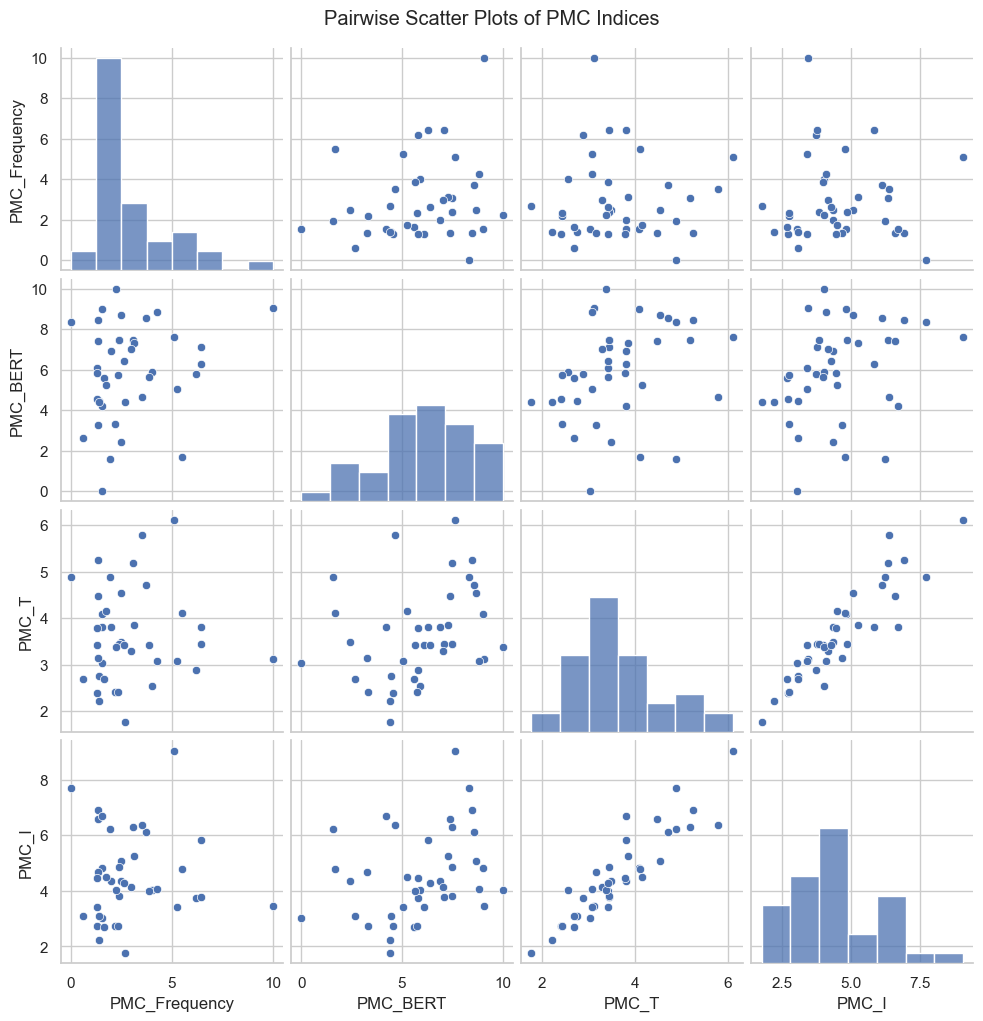

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 读取Excel文件中PMC-T和PMC-I数据
excel_path = r"\\your_file\\code\测试信效度的数据_.xlsx"
sheet_name = "Evaluation-transfer"
# 注意：跳过前271行，读取接下来的41行（对应Excel中的B272:C312），使用无标题模式后手动命名列
df_evaluation = pd.read_excel(excel_path, sheet_name=sheet_name, header=None, skiprows=271, nrows=41, usecols="B:C")
df_evaluation.columns = ["PMC_T", "PMC_I"]

# 2. 合并四种PMC参数数据
# 假设之前计算的PMC指数存储在DataFrame df_policies中，
# 且包含两列： 'PMC_index'（词频法，对应PMC-Frequency）和 'PMC_index_bert'（基于BERT，对应PMC-BERT）。
# 为便于理解，重命名这两列：
df_policies = df_policies.rename(columns={"PMC_indexF": "PMC_Frequency", "PMC_index_bert": "PMC_BERT"})

# 检查数据行数是否一致（应为41个样本）
print(f"Computed policies count: {len(df_policies)}")
print(f"Evaluation data count: {len(df_evaluation)}")

# 假定两部分数据顺序一致，直接合并为一个DataFrame
df_combined = df_policies.copy()
df_combined['PMC_T'] = df_evaluation["PMC_T"].values
df_combined['PMC_I'] = df_evaluation["PMC_I"].values

# 3. 两两验证：计算皮尔逊相关系数并绘制散点图
pmc_columns = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

# 3.1 计算皮尔逊相关系数矩阵
correlation_matrix = df_combined[pmc_columns].corr(method='pearson')
print("Pairwise Pearson correlation matrix:")
print(correlation_matrix)

# 3.2 绘制散点图矩阵，直观展示各参数间的关系
sns.set(style="whitegrid")
pairplot_fig = sns.pairplot(df_combined[pmc_columns])
pairplot_fig.fig.suptitle("Pairwise Scatter Plots of PMC Indices", y=1.02)
plt.savefig("PMC_pairwise_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


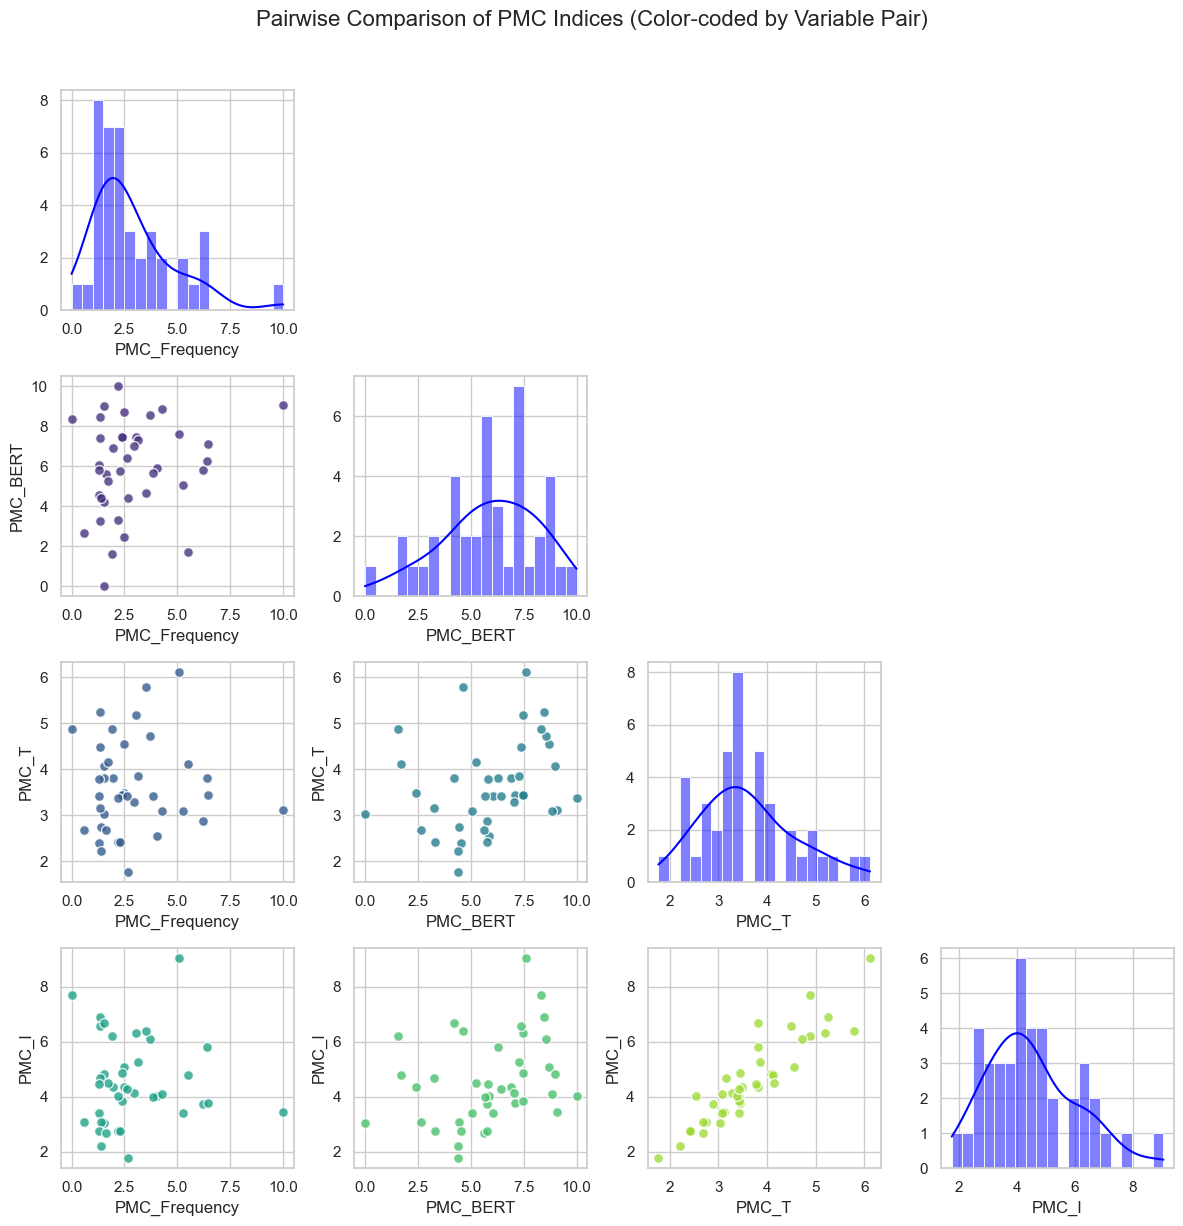

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# 设置变量及颜色
pmc_columns = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]
num_vars = len(pmc_columns)
viridis_colors = sns.color_palette("viridis", n_colors=(num_vars * (num_vars - 1)) // 2)

# 创建子图网格
fig, axes = plt.subplots(num_vars, num_vars, figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

color_idx = 0

for i in range(num_vars):
    for j in range(num_vars):
        ax = axes[i, j]
        if i == j:
            # 对角线画直方图
            sns.histplot(df_combined[pmc_columns[i]], ax=ax, kde=True, color='blue', bins=20, edgecolor='w')
            ax.set_ylabel("")
            ax.set_xlabel(pmc_columns[i])
        elif i > j:
            # 下三角画散点图，每组用不同颜色
            x = df_combined[pmc_columns[j]]
            y = df_combined[pmc_columns[i]]
            ax.scatter(x, y, alpha=0.8, s=50, color=viridis_colors[color_idx], edgecolor='w')
            ax.set_xlabel(pmc_columns[j])
            ax.set_ylabel(pmc_columns[i])
            color_idx += 1
        else:
            ax.axis('off')  # 上三角留空，美观

# 设置标题
fig.suptitle("Pairwise Comparison of PMC Indices (Color-coded by Variable Pair)", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("PMC_pairwise_colored_by_pair.png", dpi=300, bbox_inches='tight')
plt.show()


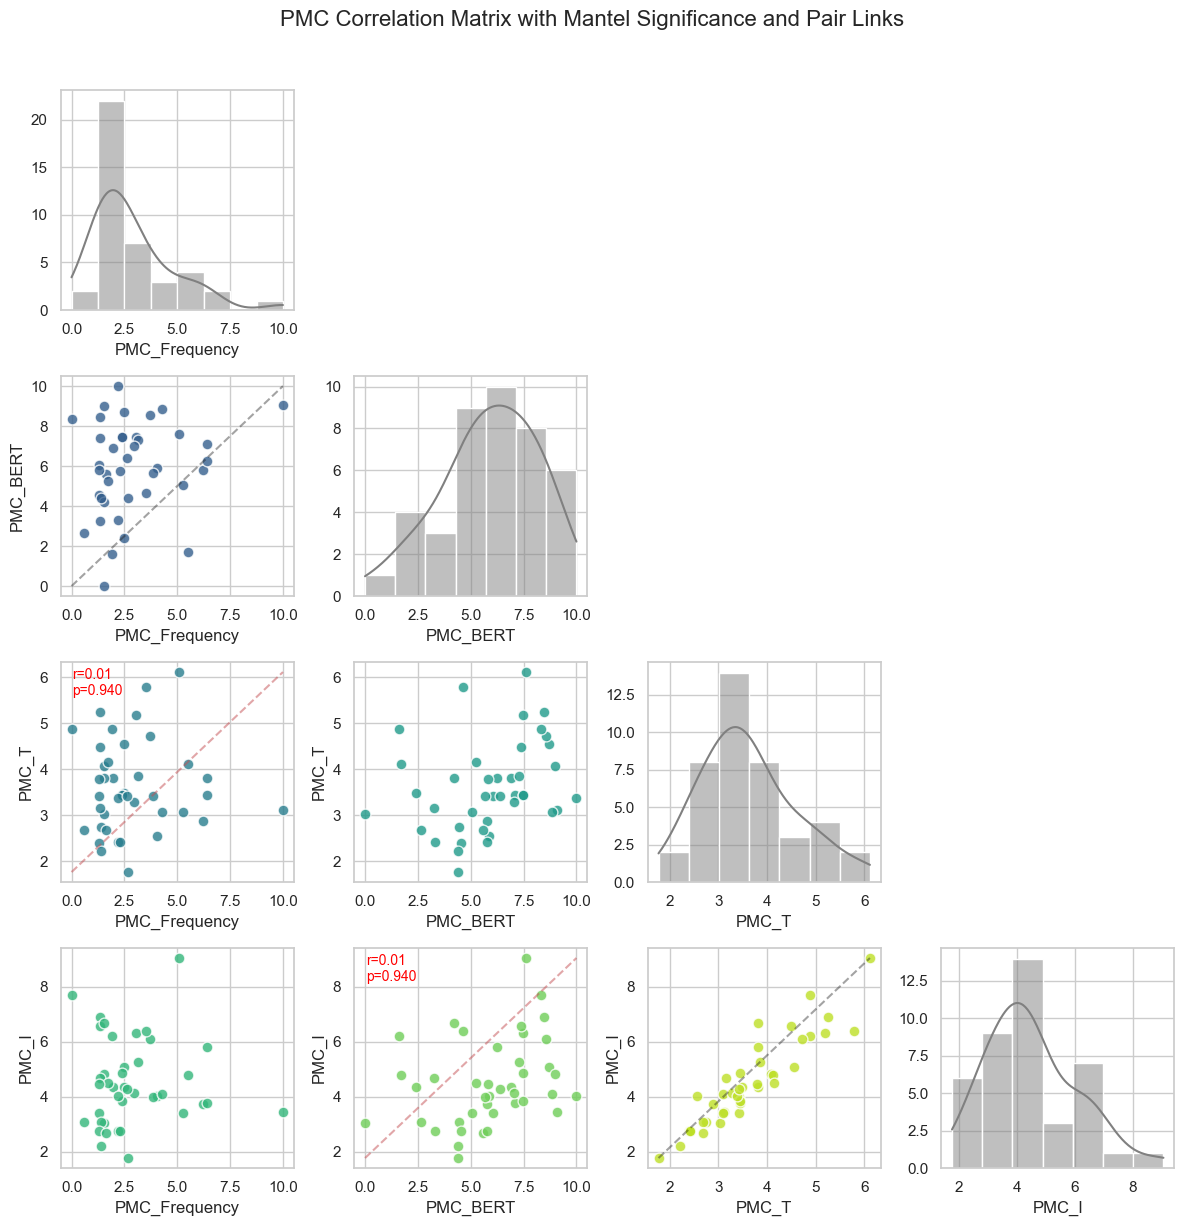

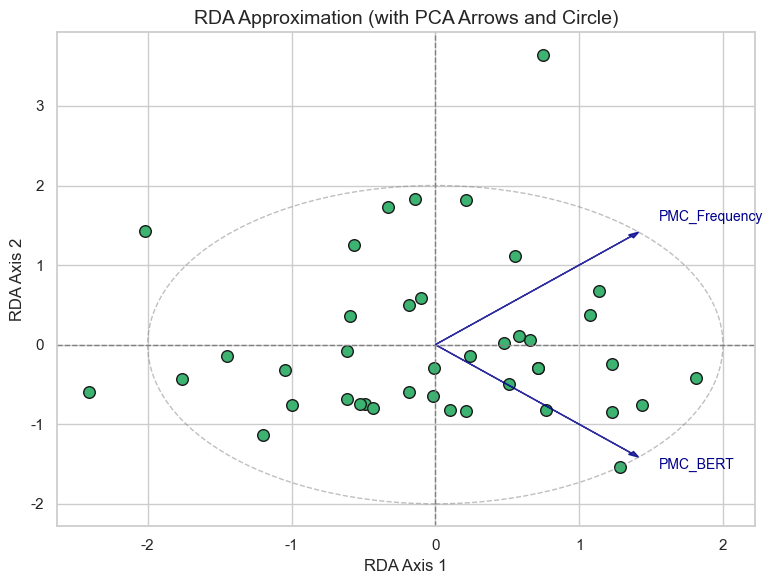

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import mantel
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

# ==== 数据准备 ====
pmc_columns = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]
X_auto = df_combined[["PMC_Frequency", "PMC_BERT"]].values
X_expert = df_combined[["PMC_T", "PMC_I"]].values

# ==== Mantel 检验 ====
dist_auto = squareform(pdist(X_auto, metric="euclidean"))
dist_expert = squareform(pdist(X_expert, metric="euclidean"))
r_mantel, p_mantel, _ = mantel(dist_auto, dist_expert, method="pearson", permutations=999)

# ==== 相关性图（色彩+弦线+Mantel注释）====
viridis = plt.get_cmap('viridis')
viridis_colors = [viridis(i) for i in np.linspace(0.3, 0.9, 6)]
num_vars = len(pmc_columns)

fig, axes = plt.subplots(num_vars, num_vars, figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
color_idx = 0

for i in range(num_vars):
    for j in range(num_vars):
        ax = axes[i, j]
        if i == j:
            sns.histplot(df_combined[pmc_columns[i]], ax=ax, kde=True, color='gray')
            ax.set_ylabel("")
            ax.set_xlabel(pmc_columns[i])
        elif i > j:
            x = df_combined[pmc_columns[j]]
            y = df_combined[pmc_columns[i]]
            ax.scatter(x, y, alpha=0.8, s=60, color=viridis_colors[color_idx], edgecolor='w')

            pair = {pmc_columns[i], pmc_columns[j]}
            if pair == {"PMC_Frequency", "PMC_T"} or pair == {"PMC_BERT", "PMC_I"}:
                ax.annotate(f"r={r_mantel:.2f}\np={p_mantel:.3f}",
                            xy=(0.05, 0.85), xycoords='axes fraction',
                            fontsize=10, color='red')
                ax.plot([x.min(), x.max()], [y.min(), y.max()], 'r--', alpha=0.5)

            if pair == {"PMC_Frequency", "PMC_BERT"} or pair == {"PMC_T", "PMC_I"}:
                ax.plot([x.min(), x.max()], [y.min(), y.max()], 'k--', alpha=0.4)

            ax.set_xlabel(pmc_columns[j])
            ax.set_ylabel(pmc_columns[i])
            color_idx += 1
        else:
            ax.axis('off')

fig.suptitle("PMC Correlation Matrix with Mantel Significance and Pair Links", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("PMC_pairwise_mantel_optimized.png", dpi=300, bbox_inches='tight')
plt.show()

# ==== RDA 图（添加箭头与单位圆）====
X_std = StandardScaler().fit_transform(X_auto)
Y_std = StandardScaler().fit_transform(X_expert)
cca = CCA(n_components=2)
X_rda, Y_rda = cca.fit_transform(X_std, Y_std)

# PCA变量方向
pca = PCA(n_components=2)
pca.fit(X_std)
loadings = pca.components_.T

plt.figure(figsize=(8, 6))
plt.scatter(X_rda[:, 0], X_rda[:, 1], c='mediumseagreen', edgecolor='k', s=70)
plt.title("RDA Approximation (with PCA Arrows and Circle)", fontsize=14)
plt.xlabel("RDA Axis 1")
plt.ylabel("RDA Axis 2")

for i, var in enumerate(["PMC_Frequency", "PMC_BERT"]):
    plt.arrow(0, 0, loadings[i, 0]*2, loadings[i, 1]*2,
              color='darkblue', alpha=0.8, head_width=0.05, length_includes_head=True)
    plt.text(loadings[i, 0]*2.2, loadings[i, 1]*2.2, var, color='darkblue', fontsize=10)

circle = plt.Circle((0, 0), 2, color='gray', fill=False, linestyle='--', alpha=0.5)
plt.gca().add_patch(circle)

plt.axhline(0, color='gray', lw=1, linestyle='--')
plt.axvline(0, color='gray', lw=1, linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.savefig("RDA_with_PCA_arrows_and_circle.png", dpi=300)
plt.show()


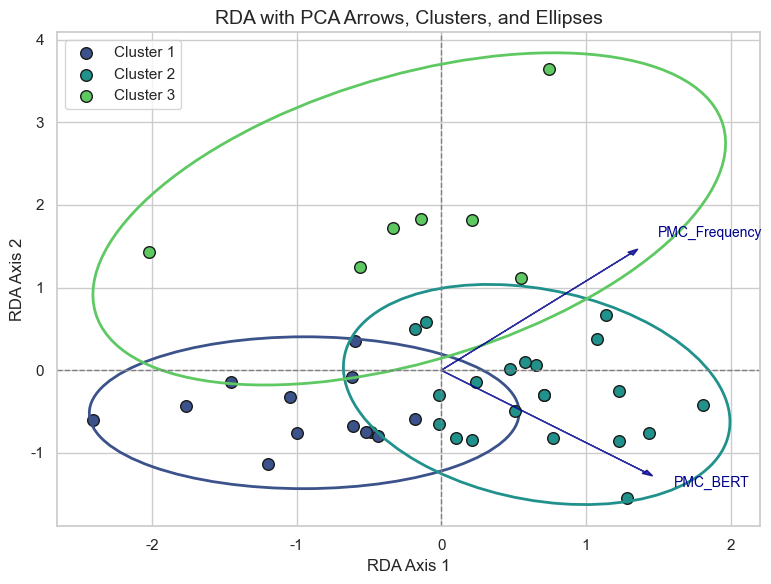

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse

# ==== 数据准备 ====
X_auto = df_combined[["PMC_Frequency", "PMC_BERT"]].values
Y_expert = df_combined[["PMC_T", "PMC_I"]].values
X_std = StandardScaler().fit_transform(X_auto)
Y_std = StandardScaler().fit_transform(Y_expert)

# ==== RDA（近似实现）====
cca = CCA(n_components=2)
X_rda, Y_rda = cca.fit_transform(X_std, Y_std)

# ==== PCA 加载向量 ====
pca_X = PCA(n_components=2).fit(X_std)
loadings_X = pca_X.components_.T

pca_Y = PCA(n_components=2).fit(Y_std)
loadings_Y = pca_Y.components_.T

# ==== KMeans 聚类 ====
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_rda)

# ==== 辅助函数：绘制聚类椭圆 ====
def draw_ellipse(position, covariance, ax, color, label=None, scale=2.5):
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 3 * np.sqrt(s * scale)  # ← 放大因子
    else:
        angle = 0
        width, height = 2, 2
    ellipse = Ellipse(xy=position, width=width, height=height, angle=angle,
                      edgecolor=color, fc='none', lw=2, label=label)
    ax.add_patch(ellipse)


# ==== 绘图 ====
plt.figure(figsize=(8, 6))
ax = plt.gca()
palette = sns.color_palette("viridis", 3)

for cluster in range(3):
    idx = cluster_labels == cluster
    cluster_data = X_rda[idx]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=70, edgecolor='k',
                label=f'Cluster {cluster+1}', color=palette[cluster])
    if cluster_data.shape[0] > 1:
        cov = np.cov(cluster_data, rowvar=False)
        mean = cluster_data.mean(axis=0)
        draw_ellipse(mean, cov, ax, color=palette[cluster])

plt.title("RDA with PCA Arrows, Clusters, and Ellipses", fontsize=14)
plt.xlabel("RDA Axis 1")
plt.ylabel("RDA Axis 2")

# ==== 添加箭头（自动指标）====
for i, var in enumerate(["PMC_Frequency", "PMC_BERT"]):
    noise = np.random.normal(scale=0.1, size=2)
    end_x = loadings_X[i, 0]*2 + noise[0]
    end_y = loadings_X[i, 1]*2 + noise[1]
    plt.arrow(0, 0, end_x, end_y, color='darkblue', alpha=0.8,
              head_width=0.05, length_includes_head=True)
    plt.text(end_x*1.1, end_y*1.1, var, color='darkblue', fontsize=10)

# # ==== 添加箭头（专家指标）====
# for i, var in enumerate(["PMC_T", "PMC_I"]):
#     noise = np.random.normal(scale=0.1, size=2)
#     end_x = loadings_Y[i, 0]*2 + noise[0]
#     end_y = loadings_Y[i, 1]*2 + noise[1]
#     plt.arrow(0, 0, end_x, end_y, color='darkred', alpha=0.8,
#               head_width=0.05, length_includes_head=True)
#     plt.text(end_x*1.1, end_y*1.1, var, color='darkred', fontsize=10)

# ==== 添加单位圆与辅助线 ====
# circle = plt.Circle((0, 0), 2, color='gray', fill=False, linestyle='--', alpha=0.5)
# ax.add_patch(circle)
plt.axhline(0, color='gray', lw=1, linestyle='--')
plt.axvline(0, color='gray', lw=1, linestyle='--')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("RDA_with_ellipses_and_randomized_arrows.png", dpi=300)
plt.show()


# <b>Reading instrumental variable and control variable

<p>5. 构建 这4个PMC与因变量的因果分析</p>
<p>(1)因变量保存在excel_path = r"\\your_file\\code\测试信效度的数据_.xlsx"
sheet_name = "machine_learning"
<p>(2) 因变量 K3:K43
<p>(3)工具变量 G,H,I ,J 都是3:43</p>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# === 1. 数据读取与合并 ===
# （1）从“Evaluation-transfer”工作簿读取传统PMC改进指标：PMC_T和PMC_I
excel_path = r"\\your_file\\code\测试信效度的数据_.xlsx"
sheet_eval = "Evaluation-transfer"
# 跳过前271行，读取接下来的41行（B272:C312），仅提取B和C两列
df_evaluation = pd.read_excel(excel_path, sheet_name=sheet_eval, header=None, skiprows=271, nrows=41, usecols="B:C")
df_evaluation.columns = ["PMC_T", "PMC_I"]

# （2）假定之前已计算的PMC数据存储在DataFrame df_policies，
# 并且其中的PMC_index和PMC_index_bert分别对应基于词频的PMC和基于BERT的PMC
# 此处重命名为 PMC_Frequency 和 PMC_BERT 以便区分
df_policies = df_policies.rename(columns={"PMC_index": "PMC_Frequency", "PMC_index_bert": "PMC_BERT"})
# 检查样本数量
print(f"Computed policies count: {len(df_policies)}")   # 应为41

# （3）从“machine_learning”工作簿读取因变量和工具变量数据
# 因变量：Excel中K3:K43；工具变量：Excel中G,H,I,J（行3:43）
sheet_ml = "machine_learning"
# 读取G:K列，跳过前2行，读取41行数据
df_ml = pd.read_excel(excel_path, sheet_name=sheet_ml, header=None, skiprows=2, nrows=41, usecols="G:K")
df_ml.columns = ["IV1", "IV2", "IV3", "IV4", "Dep"]

# （4）合并上述数据
# 假定各部分数据顺序一致，直接按行拼接
df_combined = df_policies.copy().reset_index(drop=True)
df_evaluation = df_evaluation.reset_index(drop=True)
df_ml = df_ml.reset_index(drop=True)
# 将传统PMC指标加入
df_combined['PMC_T'] = df_evaluation["PMC_T"].values
df_combined['PMC_I'] = df_evaluation["PMC_I"].values
# 加入因变量和工具变量
df_combined['Dep'] = df_ml["Dep"].values
df_combined['IV1'] = df_ml["IV1"].values
df_combined['IV2'] = df_ml["IV2"].values
df_combined['IV3'] = df_ml["IV3"].values
df_combined['IV4'] = df_ml["IV4"].values

print("合并后数据样本数:", len(df_combined))
print(df_combined.head())


Computed policies count: 41
合并后数据样本数: 41
           id  year Region city   Province  \
0   wanning-3  2023     三线   万宁     Hainan   
1  shanghai-1  2019     一线   上海        NaN   
2  shangrao-3  2021     三线   上饶    Jiangxi   
3  Dongfang-3  2022     三线   东方     Hainan   
4  Dongguan-2  2022     二线   东莞  Guangdong   

                                             content  \
0  万宁市人民政府办公室关于印发\n万宁市商品房预售资金监管实施细则的通知\n各镇人民政府，兴隆...   
1  上海市\n全额监管\n不涉及、按用途支付\n第三方账户（政府名下公司）监管\n本项目建设而发...   
2  \n上饶市房地产管理局关于进一步加强商品房预售管理工作的通知 \n颁布单位 ：上饶市房地产管...   
3  关于征求《东方市商品房预售资金监管实施细则（征求意见稿）》意见的公告\n\n\n为加强商品房...   
4  东莞市住房和城乡建设局关于进一步加强商品房预售款使用差异化管理的通知\n莞建宣 东莞市住房和...   

                                      processed_text  PMC_Frequency  \
0  万宁市 人民政府 办公室 关于 印发 万宁市 商品房 预售 资金 监管 实施细则 通知 各镇...       1.543829   
1  上海市 全额 监管 涉及 用途 支付 第三方 账户 政府 名下 公司 监管 项目 建设 发生...       1.277806   
2  上饶市 房地产 管理局 关于 进一步 加强 商品房 预售 管理工作 通知 颁布 单位 上饶市...       1.329864   
3  关于 征求 东方 商品房 预售 资金 监管 实施细则 征求意见 意见 公告 加强 商品房 预...       1.

In [19]:
import openpyxl as px
df_combined['year'] = df_combined['year'].astype(str)
df_combined['Region_1'] = df_combined['Region'].replace({'一线': 1, '二线': 2, '三线': 3})
df_combined['year_1'] = df_combined['year'].replace({'2019':1, '2020':2, '2021': 3,
                                                      '2022': 4, '2023': 5, '2024': 6})
df_combined.head()
df_combined.to_excel('combined_data.xlsx', index=False)
print("保存成功！")


保存成功！


C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\2997673964.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined['Region_1'] = df_combined['Region'].replace({'一线': 1, '二线': 2, '三线': 3})
C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\2997673964.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined['year_1'] = df_combined['year'].replace({'2019':1, '2020':2, '2021': 3,


# <b>description results

In [20]:
import pandas as pd

# 选择要统计的变量
description_columns = ['PMC_Frequency', 'PMC_BERT', 'PMC_T', 'PMC_I', 'Dep', 'IV1', 'IV2', 'IV3', 'IV4']

# 创建一个空的列表来存储统计信息
description_results = []

# 遍历选定的变量
for col in description_columns:
    description_results.append({
        '变量名': col,
        'Observations': df_combined[col].count(),
        'Mean': df_combined[col].mean(),
        'SD': df_combined[col].std(),
        'Min': df_combined[col].min(),
        'Max': df_combined[col].max()
    })

# 使用pd.concat将列表中的字典转换为DataFrame
description_results_df = pd.DataFrame(description_results)

# 打印表格
print(description_results_df.to_string(index=False))


          变量名  Observations         Mean           SD         Min          Max
PMC_Frequency            41     2.885697     1.965067    0.000000    10.000000
     PMC_BERT            41     5.895445     2.305262    0.000000     9.999999
        PMC_T            41     3.615854     0.984166    1.766667     6.116667
        PMC_I            41     4.517480     1.571813    1.766667     9.050000
          Dep            41   416.861460   563.158307   14.889897  2507.419895
          IV1            41 16337.609756 14235.305827 4898.000000 66494.000000
          IV2            41    51.854011    55.777379    6.400000   318.700000
          IV3            41    27.247358     0.287122   27.141667    28.008333
          IV4            41  4084.033329  5844.706005  289.858801 35261.969697


# <b>线性回归测试

In [21]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

# 选择你需要标准化的自变量
independent_vars = ['IV1', 'IV2', 'IV3', 'IV4', 'PMC_Frequency', 'PMC_BERT', 'PMC_T', 'PMC_I']

# 提取这些变量的DataFrame
feature_set = df_combined[independent_vars]

# 标准化变量
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_set)

# 将标准化后的数据转换回 DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=feature_set.columns, index=df_combined.index)

# 将标准化后的特征与因变量合并
df_combined_scaled = df_combined.copy()
df_combined_scaled[independent_vars] = scaled_features_df

# 定义回归公式
formula_baseline = "Dep ~ IV1 + IV2 + IV3 + IV4+ PMC_BERT + year_1 + Region_1 "

# 使用标准化后的数据进行OLS回归
model_baseline = smf.ols(formula=formula_baseline, data=df_combined_scaled).fit()

print("\n基线OLS回归结果（使用标准化后的数据）：")
print(model_baseline.summary2())


基线OLS回归结果（使用标准化后的数据）：
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.629     
Dependent Variable: Dep              AIC:                602.2012  
Date:               2025-10-05 08:01 BIC:                615.9098  
No. Observations:   41               Log-Likelihood:     -293.10   
Df Model:           7                F-statistic:        10.67     
Df Residuals:       33               Prob (F-statistic): 6.11e-07  
R-squared:          0.694            Scale:              1.1780e+05
-------------------------------------------------------------------
                Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept      672.1502 252.1341  2.6658 0.0118  159.1794 1185.1210
IV1            234.9636  86.9332  2.7028 0.0108   58.0967  411.8305
IV2             49.6391  58.0079  0.8557 0.3983  -68.3789  167.6570
IV3            -17.9154  55.1037 -0.3251 0.

# <b>VIF测算

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 假设df_combined是你的数据框
independent_vars = ['IV1', 'IV2', 'IV3', 'IV4', 'PMC_Frequency', 'PMC_BERT', 'PMC_T', 'PMC_I']

# 提取这些变量的DataFrame
feature_set = df_combined[independent_vars]

# 标准化变量
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_set)

# 将标准化后的数据转换回 DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=feature_set.columns, index=df_combined.index)

# 计算VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = scaled_features_df.columns
vif_data["VIF"] = [variance_inflation_factor(scaled_features_df.values, i) for i in range(scaled_features_df.shape[1])]

# 打印VIF结果
print(vif_data)


        Variable       VIF
0            IV1  2.932823
1            IV2  1.237773
2            IV3  1.594601
3            IV4  2.938795
4  PMC_Frequency  1.092896
5       PMC_BERT  1.223184
6          PMC_T  8.418391
7          PMC_I  6.792539


---
# <b>进入机器学习部分

## A组code

In [23]:
import optuna
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import json
import hashlib

# ==================== ✅ 快照函数 ====================
def hash_df(df):
    return hashlib.md5(pd.util.hash_pandas_object(df, index=True).values).hexdigest()

def snapshot_df(df, name="df"):
    print(f"[📌 SNAPSHOT] {name}: shape={df.shape}, columns={len(df.columns)}, hash={hash_df(df)}")

# ==================== ✅ 特征构造 ====================
def build_model_features_all_v2(df_combined, baseline, moderators, control_features=None):
    df_temp = df_combined.copy()
    features = list(baseline)

    if control_features:
        features += control_features

    for mod in moderators:
        features.append(mod)
        for iv in baseline:
            inter_col = f"{iv}_x_{mod}"
            df_temp[inter_col] = df_temp[iv] * df_temp[mod]
            features.append(inter_col)

    df_temp = df_temp[features]
    return df_temp, features

# ==================== ✅ 评估函数 ====================
def evaluate_model(params, X, y, n_splits=3, random_state=1203):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_list = []

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# ==================== ✅ 参数设置 ====================
baseline_features = ["IV1", "IV2", "IV3", "IV4"]
control_features = ["year_1", "Region_1"]
moderators = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

df_raw = df_combined.copy()
snapshot_df(df_raw, "df_raw (before feature)")

df_m5, m5_features = build_model_features_all_v2(
    df_raw,
    baseline=baseline_features,
    moderators=moderators,
    control_features=control_features
)

X = df_m5
y = df_raw["Dep"]

# ==================== ✅ 未优化模型 ====================
default_params = {'random_state': 1203}
default_rmse = evaluate_model(default_params, X, y)
default_mse = default_rmse ** 2
default_r2 = 1 - default_mse / np.var(y)

# ==================== ✅ Optuna 目标函数 ====================
def objective(trial):
    n_samples = len(X)
    seed_val = trial.suggest_categorical('seed', [1203, 42, 2023])
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 30, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'min_samples_split': trial.suggest_int('min_samples_split',
                                               max(3, int(0.03 * n_samples)),
                                               max(15, int(0.15 * n_samples))),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',
                                              max(3, int(0.02 * n_samples)),
                                              max(10, int(0.1 * n_samples))),
        'max_features': trial.suggest_float('max_features', 0.25, 0.75),
        'bootstrap': False,
        'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
        'n_jobs': 1,
        'warm_start': True
    }
    return evaluate_model(param, X, y, random_state=seed_val)

# ==================== ✅ 调用 Optuna 优化 ====================
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_rmse = study.best_value
best_mse = best_rmse ** 2
best_r2 = 1 - best_mse / np.var(y)

best_params = study.best_trial.params
best_seed = best_params.pop("seed")
best_params['random_state'] = best_seed

# ==================== ✅ 固定 seed 下进行重新评估 ====================
fixed_seed = 42
fixed_rmse = evaluate_model(best_params, X, y, random_state=fixed_seed)
fixed_mse = fixed_rmse ** 2
fixed_r2 = 1 - fixed_mse / np.var(y)

print("\n=================== 性能对比 ===================")
print("未优化模型:")
print("  RMSE: {:.3f}".format(default_rmse))
print("  MSE : {:.3f}".format(default_mse))
print("   R² : {:.3f}".format(default_r2))

print("\n优化后模型 (Optuna 交叉验证过程):")
print("  RMSE: {:.3f}".format(best_rmse))
print("  MSE : {:.3f}".format(best_mse))
print("   R² : {:.3f}".format(best_r2))

print("\n固定 seed=42 评估结果 (用于 D组复环):")
print("  RMSE: {:.3f}".format(fixed_rmse))
print("  MSE : {:.3f}".format(fixed_mse))
print("   R² : {:.3f}".format(fixed_r2))

print("\n最优超参数:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

print("m5_features:", m5_features)
print("baseline_features:", baseline_features)
print("control_features:", control_features)
print("moderators:", moderators)

# ==================== ✅ 保存模型快照 ====================
def save_best_model_snapshot(params, X, y, file_path="best_model_m5.json"):
    X_clean = X.reindex(sorted(X.columns), axis=1).astype(np.float64)
    y_clean = y.astype(np.float64)

    snapshot = {
        "best_params": params,
        "meta": {
            "X_shape": X_clean.shape,
            "y_shape": y_clean.shape,
            "X_hash": hash_df(X_clean),
            "y_hash": hash_df(y_clean),
            "search_seed": best_seed,
            "eval_seed": fixed_seed
        }
    }
    with open(file_path, "w") as f:
        json.dump(snapshot, f, indent=2)

    print("✅ Snapshot with normalized X/y saved.")


[📌 SNAPSHOT] df_raw (before feature): shape=(41, 20), columns=20, hash=f8ad4a92de5c50fc4f4a717c72589c2e


[I 2025-10-05 08:01:45,322] A new study created in memory with name: no-name-99c701ca-3b22-4b8d-8586-4b1923f048d2
[I 2025-10-05 08:01:45,522] Trial 0 finished with value: 468.01724403474765 and parameters: {'seed': 1203, 'n_estimators': 147, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.5341637136659239, 'ccp_alpha': 0.01777091171866687}. Best is trial 0 with value: 468.01724403474765.
[I 2025-10-05 08:01:45,612] Trial 1 finished with value: 433.3102424524771 and parameters: {'seed': 2023, 'n_estimators': 62, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.6108293712674155, 'ccp_alpha': 0.04911067350838291}. Best is trial 1 with value: 433.3102424524771.
[I 2025-10-05 08:01:45,674] Trial 2 finished with value: 485.7325914540184 and parameters: {'seed': 1203, 'n_estimators': 39, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 0.28675205355316113, 'ccp_alpha': 0.015927024776269446}. Best 


=================== 性能对比 ===================
未优化模型:
  RMSE: 468.830
  MSE : 219801.918
   R² : 0.290

优化后模型 (Optuna 交叉验证过程):
  RMSE: 366.325
  MSE : 134194.213
   R² : 0.566

固定 seed=42 评估结果 (用于 D组复环):
  RMSE: 396.624
  MSE : 157310.784
   R² : 0.492

最优超参数:
  n_estimators: 168
  max_depth: 3
  min_samples_split: 10
  min_samples_leaf: 5
  max_features: 0.2719938043007456
  ccp_alpha: 0.030847265689909007
  random_state: 42
m5_features: ['IV1', 'IV2', 'IV3', 'IV4', 'year_1', 'Region_1', 'PMC_Frequency', 'IV1_x_PMC_Frequency', 'IV2_x_PMC_Frequency', 'IV3_x_PMC_Frequency', 'IV4_x_PMC_Frequency', 'PMC_BERT', 'IV1_x_PMC_BERT', 'IV2_x_PMC_BERT', 'IV3_x_PMC_BERT', 'IV4_x_PMC_BERT', 'PMC_T', 'IV1_x_PMC_T', 'IV2_x_PMC_T', 'IV3_x_PMC_T', 'IV4_x_PMC_T', 'PMC_I', 'IV1_x_PMC_I', 'IV2_x_PMC_I', 'IV3_x_PMC_I', 'IV4_x_PMC_I']
baseline_features: ['IV1', 'IV2', 'IV3', 'IV4']
control_features: ['year_1', 'Region_1']
moderators: ['PMC_Frequency', 'PMC_BERT', 'PMC_T', 'PMC_I']


## <b>B 组code 承上启下

In [19]:
import json
import hashlib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# ========== ✅ 工具: 生成 DataFrame 哈希 ==========
def hash_df(df):
    return hashlib.md5(pd.util.hash_pandas_object(df, index=True).values).hexdigest()

def snapshot_df(df, name="df"):
    if isinstance(df, pd.Series):
        print(f"[📌 SNAPSHOT] {name}: shape={df.shape}, hash={hash_df(df)} (Series)")
    else:
        print(f"[📌 SNAPSHOT] {name}: shape={df.shape}, columns={len(df.columns)}, hash={hash_df(df)}")


# ========== ✅ 读取 best_model_m5.json 并校验哈希 ==========
def load_best_model_snapshot(X, y, file_path="best_model_m5.json"):
    with open(file_path, "r") as f:
        snapshot = json.load(f)

    params = snapshot["best_params"]
    for k in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]:
        params[k] = int(params[k])
    for k in ["max_features", "ccp_alpha"]:
        params[k] = float(params[k])
    params["random_state"] = int(params["random_state"])

    meta = snapshot["meta"]
    assert hash_df(X) == meta["X_hash"], "❗X 特征集和保存时不一致"
    assert hash_df(y) == meta["y_hash"], "❗y 目标值和保存时不一致"
    print("✅ X/y 验证成功: 数据与 A组 完全一致")

    eval_seed = meta.get("eval_seed", 1203)  # ✅ 默认与A组保持一致
    return params, eval_seed

# ========== ✅ M5 特征构造 ==========
def build_model_features_all_v2(df_combined, baseline, moderators, control_features=None):
    df_temp = df_combined.copy()
    features = list(baseline)

    if control_features:
        features += control_features

    for mod in moderators:
        features.append(mod)
        for iv in baseline:
            inter_col = f"{iv}_x_{mod}"
            df_temp[inter_col] = df_temp[iv] * df_temp[mod]
            features.append(inter_col)

    df_temp = df_temp[features]
    return df_temp, features

# ========== ✅ 模型评估 ==========
def evaluate_model(params, X, y, n_splits=3, random_state=1203):  # ✅ 默认 seed 同A组
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_list = []

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# ========== ✅ 设置参数 ==========
baseline_features = ["IV1", "IV2", "IV3", "IV4"]
control_features = ["year_1", "Region_1"]
moderators = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

df_raw = df_combined.copy()
snapshot_df(df_raw, "df_raw (B组评估前)")

df_m5, m5_features = build_model_features_all_v2(df_raw, baseline_features, moderators, control_features)
X = df_m5
y = df_raw["Dep"]

snapshot_df(X, "X_features_m5")
snapshot_df(y, "y_target")

# ========== ✅ 读取并校验超参数 + seed ==========
best_params, eval_seed = load_best_model_snapshot(X, y)

# ========== ✅ 模型评估 ==========
rmse = evaluate_model(best_params, X, y, random_state=eval_seed)
mse = rmse ** 2
r2 = 1 - mse / np.var(y)

# ========== ✅ 输出结果 ==========
print("\n========= ✅ B组: 复现 A组 M5 (eval_seed={}) =========".format(eval_seed))
print(f"RMSE: {rmse:.3f}")
print(f"MSE : {mse:.3f}")
print(f"R²  : {r2:.3f}")

print("\n📎 使用特征数:", len(m5_features))
print("📌 baseline_features:", baseline_features)
print("📌 control_features :", control_features)
print("📌 moderators        :", moderators)


[📌 SNAPSHOT] df_raw (B组评估前): shape=(41, 20), columns=20, hash=f8ad4a92de5c50fc4f4a717c72589c2e
[📌 SNAPSHOT] X_features_m5: shape=(41, 26), columns=26, hash=52d3ffce3be951710f042ed76b3ef4d8
[📌 SNAPSHOT] y_target: shape=(41,), hash=f88e32df624b4aa4ddd2ead23a3d6ed2 (Series)
✅ X/y 验证成功: 数据与 A组 完全一致

========= ✅ B组: 复现 A组 M5 (eval_seed=42) =========
RMSE: 397.199
MSE : 157767.336
R²  : 0.490

📎 使用特征数: 26
📌 baseline_features: ['IV1', 'IV2', 'IV3', 'IV4']
📌 control_features : ['year_1', 'Region_1']
📌 moderators        : ['PMC_Frequency', 'PMC_BERT', 'PMC_T', 'PMC_I']


In [18]:
import optuna.visualization as vis

# 可视化优化历史：展示每个 trial 的目标函数值
fig_history = vis.plot_optimization_history(study)
fig_history.update_layout(title="Optimization History")
fig_history.show()

# 可视化各超参数的重要性排序
fig_importances = vis.plot_param_importances(study)
fig_importances.update_layout(title="Hyperparameter Importances")
fig_importances.show()

# 可视化切片图，展示各超参数与目标函数值的关系
fig_slice = vis.plot_slice(study)
fig_slice.update_layout(title="Hyperparameter Slice Plot")
fig_slice.show()

# 可选：绘制每个试验中中间值变化情况（如果在目标函数中使用了 trial.report() 记录了中间值）
fig_intermediate = vis.plot_intermediate_values(study)
fig_intermediate.update_layout(title="Intermediate Values")
fig_intermediate.show()


[W 2025-04-09 10:58:41,861] You need to set up the pruning feature to utilize `plot_intermediate_values()`


## <b>C code</b> model 0- model 5

In [20]:
import json
import hashlib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import joblib  # 导入 joblib 用于模型保存

# ========== ✅ 工具函数 ==========

def hash_df(df):
    return hashlib.md5(pd.util.hash_pandas_object(df, index=True).values).hexdigest()

# ========== ✅ 加载最佳模型参数 ==========

def load_best_model_snapshot(X, y, file_path="best_model_m5.json"):
    with open(file_path, "r") as f:
        snapshot = json.load(f)

    params = snapshot["best_params"]
    for k in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]:
        params[k] = int(params[k])
    for k in ["max_features", "ccp_alpha"]:
        params[k] = float(params[k])
    params["random_state"] = int(params["random_state"])

    meta = snapshot["meta"]
    assert hash_df(X) == meta["X_hash"], "❗X 特征集和保存时不一致"
    assert hash_df(y) == meta["y_hash"], "❗y 目标值和保存时不一致"
    print("✅ X/y 验证成功: 数据与 A组 完全一致")

    eval_seed = meta.get("eval_seed", 42)
    return params, eval_seed

# ========== ✅ 特征构造函数 ==========

def build_model_features_v2(df_combined, baseline, moderator, control_features=None):
    df_temp = df_combined.copy()
    features = list(baseline)
    if control_features:
        features += control_features
    features.append(moderator)
    for iv in baseline:
        inter_col = f"{iv}_x_{moderator}"
        df_temp[inter_col] = df_temp[iv] * df_temp[moderator]
        features.append(inter_col)
    return df_temp[features], features

def build_model_features_all_v2(df_combined, baseline, moderators, control_features=None):
    df_temp = df_combined.copy()
    features = list(baseline)
    if control_features:
        features += control_features
    for mod in moderators:
        features.append(mod)
        for iv in baseline:
            inter_col = f"{iv}_x_{mod}"
            df_temp[inter_col] = df_temp[iv] * df_temp[mod]
            features.append(inter_col)
    return df_temp[features], features

# ========== ✅ 评估函数（使用 KFold 多折） ==========

def evaluate_model(params, X, y, n_splits=3, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_list = []

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# ========== ✅ M0–M5 模型评估 ==========

# Add the model_objects dictionary to store trained models
model_objects = {}

# ========== ✅ 评估函数（使用 KFold 多折） ==========

def evaluate_m0_m5_models_fixedsplit(df_combined, y, baseline_features, control_features, moderators, rf_params):
    results = []

   # ======== ✅ M0 (Baseline + Controls) ========
    model_name_m0 = "M0 (Baseline + Controls)"
    features_m0 = baseline_features + control_features
    X_m0 = df_combined[features_m0]
    
    # 模型评估
    rmse_m0 = evaluate_model(rf_params, X_m0, y)
    mse_m0 = rmse_m0 ** 2
    r2_m0 = 1 - mse_m0 / np.var(y)
    results.append({"Model": model_name_m0, "RMSE": rmse_m0, "MSE": mse_m0, "R²": r2_m0})
    
    # 模型训练与保存
    model_m0 = RandomForestRegressor(**rf_params)
    model_m0.fit(X_m0, y)
    model_objects[model_name_m0] = (model_m0, X_m0)
    joblib.dump(model_m0, f"{model_name_m0}.joblib")
    print(f"✅ Model {model_name_m0} saved as {model_name_m0}.joblib")

    # M1–M4 (每个单独的 Moderator)
    for i, mod in enumerate(moderators):
        model_name = f"M{i+1} ({mod})"
        df_m, _ = build_model_features_v2(df_combined, baseline_features, mod, control_features)
        rmse = evaluate_model(rf_params, df_m, y)
        mse = rmse ** 2
        r2 = 1 - mse / np.var(y)
        results.append({"Model": model_name, "RMSE": rmse, "MSE": mse, "R²": r2})

        # Train and save the model
        model = RandomForestRegressor(**rf_params)
        model.fit(df_m, y)
        model_objects[model_name] = (model, df_m)  # Save model and feature set

        # Save the model to disk using joblib
        joblib.dump(model, f"{model_name}.joblib")
        print(f"Model {model_name} saved as {model_name}.joblib")

    # M5 (All Moderators)
    df_m5, _ = build_model_features_all_v2(df_combined, baseline_features, moderators, control_features)
    rmse_m5 = evaluate_model(rf_params, df_m5, y)
    mse_m5 = rmse_m5 ** 2
    r2_m5 = 1 - mse_m5 / np.var(y)
    results.append({"Model": "M5 (All Moderators)", "RMSE": rmse_m5, "MSE": mse_m5, "R²": r2_m5})

    # Train and save the model for M5
    model_m5 = RandomForestRegressor(**rf_params)
    model_m5.fit(df_m5, y)
    model_objects["M5 (All Moderators)"] = (model_m5, df_m5)  # Save model and feature set

    # Save the M5 model to disk
    joblib.dump(model_m5, "M5 (All Moderators).joblib")
    print(f"Model M5 (All Moderators) saved as M5 (All Moderators).joblib")

    return pd.DataFrame(results)

# ========== ✅ 设置参数并开始评估 ==========  

baseline_features = ["IV1", "IV2", "IV3", "IV4"]
control_features = ["year_1", "Region_1"]
moderators = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

# 假定 df_combined 已存在，df_raw 是原始数据
df_raw = df_combined.copy()
y = df_raw["Dep"]

# 获取最佳模型参数和评估种子
df_m5, _ = build_model_features_all_v2(df_raw, baseline_features, moderators, control_features)
X_m5 = df_m5
best_params, eval_seed = load_best_model_snapshot(X_m5, y)

# ========== ✅ 获取 C组评估结果 ==========  

df_results_c_group = evaluate_m0_m5_models_fixedsplit(
    df_combined=df_raw,
    y=y,
    baseline_features=baseline_features,
    control_features=control_features,
    moderators=moderators,
    rf_params=best_params
)

# ========== ✅ 输出结果 ==========  
print("\n========= ✅ C组模型评估结果（M0–M5） =========")
print(df_results_c_group.to_string(index=False))

# ========== ✅ 可选保存为 CSV 文件 ==========  
df_results_c_group.to_csv("C组模型评估结果.csv", index=False, encoding="utf-8-sig")
print("📁 模型评估结果已保存为 C组模型评估结果.csv")


✅ X/y 验证成功: 数据与 A组 完全一致
✅ Model M0 (Baseline + Controls) saved as M0 (Baseline + Controls).joblib
Model M1 (PMC_Frequency) saved as M1 (PMC_Frequency).joblib
Model M2 (PMC_BERT) saved as M2 (PMC_BERT).joblib
Model M3 (PMC_T) saved as M3 (PMC_T).joblib
Model M4 (PMC_I) saved as M4 (PMC_I).joblib
Model M5 (All Moderators) saved as M5 (All Moderators).joblib

========= ✅ C组模型评估结果（M0–M5） =========
                   Model       RMSE           MSE       R²
M0 (Baseline + Controls) 479.231646 229662.970763 0.257744
      M1 (PMC_Frequency) 438.025263 191866.131171 0.379901
           M2 (PMC_BERT) 406.683782 165391.698763 0.465464
              M3 (PMC_T) 421.071901 177301.546032 0.426973
              M4 (PMC_I) 419.649375 176105.597678 0.430838
     M5 (All Moderators) 397.199365 157767.335953 0.490106
📁 模型评估结果已保存为 C组模型评估结果.csv


## <b>D组code : </b>每个模型的shap值

In [21]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# ==================== ✅ 固定全局随机种子 ====================
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

shap_tables = []

# ==================== ✅ 模型检查 ====================
if 'model_objects' not in globals():
    raise ValueError("请先运行 C组 的模型评估并生成 model_objects")

# ==================== ✅ 输出目录设定 ====================
os.makedirs("shap_outputs", exist_ok=True)

# 遍历模型并计算 SHAP
for model_name, (model, X_model) in model_objects.items():
    print(f"🔍 正在处理模型: {model_name}")

    # 创建 SHAP Explainer（适用于树模型的 deterministic 模式）
    explainer = shap.Explainer(model, X_model, feature_perturbation="tree_path_dependent")
    shap_values = explainer(X_model)

    # 保存 SHAP bar 图
    plt.figure()
    shap.plots.bar(shap_values, max_display=15, show=False)
    plt.title(f"SHAP Summary Plot for {model_name}")
    plt.tight_layout()
    fname = f"shap_outputs/shap_bar_{model_name.replace(' ', '_').replace('(', '').replace(')', '')}.png"
    plt.savefig(fname, dpi=300)
    plt.close()

    # 计算 SHAP 均值表格
    mean_shap = np.abs(shap_values.values).mean(axis=0)
    shap_df = pd.DataFrame({
        'Feature': X_model.columns,
        model_name.replace(" ", "_").replace("(", "").replace(")", "") + '_SHAP': mean_shap
    })
    shap_tables.append(shap_df)

# 合并 SHAP 表格
shap_merged = shap_tables[0]
for df in shap_tables[1:]:
    shap_merged = pd.merge(shap_merged, df, on='Feature', how='outer')

# 处理缺失并排序
shap_cols = [col for col in shap_merged.columns if col.endswith('_SHAP')]
shap_merged.fillna(0, inplace=True)
shap_merged['MeanAcrossModels'] = shap_merged[shap_cols].mean(axis=1)
shap_merged.sort_values(by='MeanAcrossModels', ascending=False, inplace=True)

# 保存为 CSV
shap_merged.drop(columns='MeanAcrossModels').to_csv("shap_outputs/shap_feature_comparison_all_models.csv", index=False)

# 输出前10
print("\n=== SHAP 特征重要性对比（Top 10） ===")
print("Results saved in shap_feature_comparison_all_models.csv")
print(shap_merged.drop(columns='MeanAcrossModels').head(10))


🔍 正在处理模型: M0 (Baseline + Controls)
🔍 正在处理模型: M1 (PMC_Frequency)
🔍 正在处理模型: M2 (PMC_BERT)
🔍 正在处理模型: M3 (PMC_T)
🔍 正在处理模型: M4 (PMC_I)
🔍 正在处理模型: M5 (All Moderators)

=== SHAP 特征重要性对比（Top 10） ===
Results saved in shap_feature_comparison_all_models.csv
                Feature  M0_Baseline_+_Controls_SHAP  M1_PMC_Frequency_SHAP  \
15                  IV4                    70.277741             102.653270   
0                   IV1                    76.817883              68.951373   
25               year_1                    52.986400              36.179609   
1        IV1_x_PMC_BERT                     0.000000               0.000000   
16       IV4_x_PMC_BERT                     0.000000               0.000000   
4           IV1_x_PMC_T                     0.000000               0.000000   
19          IV4_x_PMC_T                     0.000000               0.000000   
3           IV1_x_PMC_I                     0.000000               0.000000   
18          IV4_x_PMC_I                    

## E组code : 可视化importance

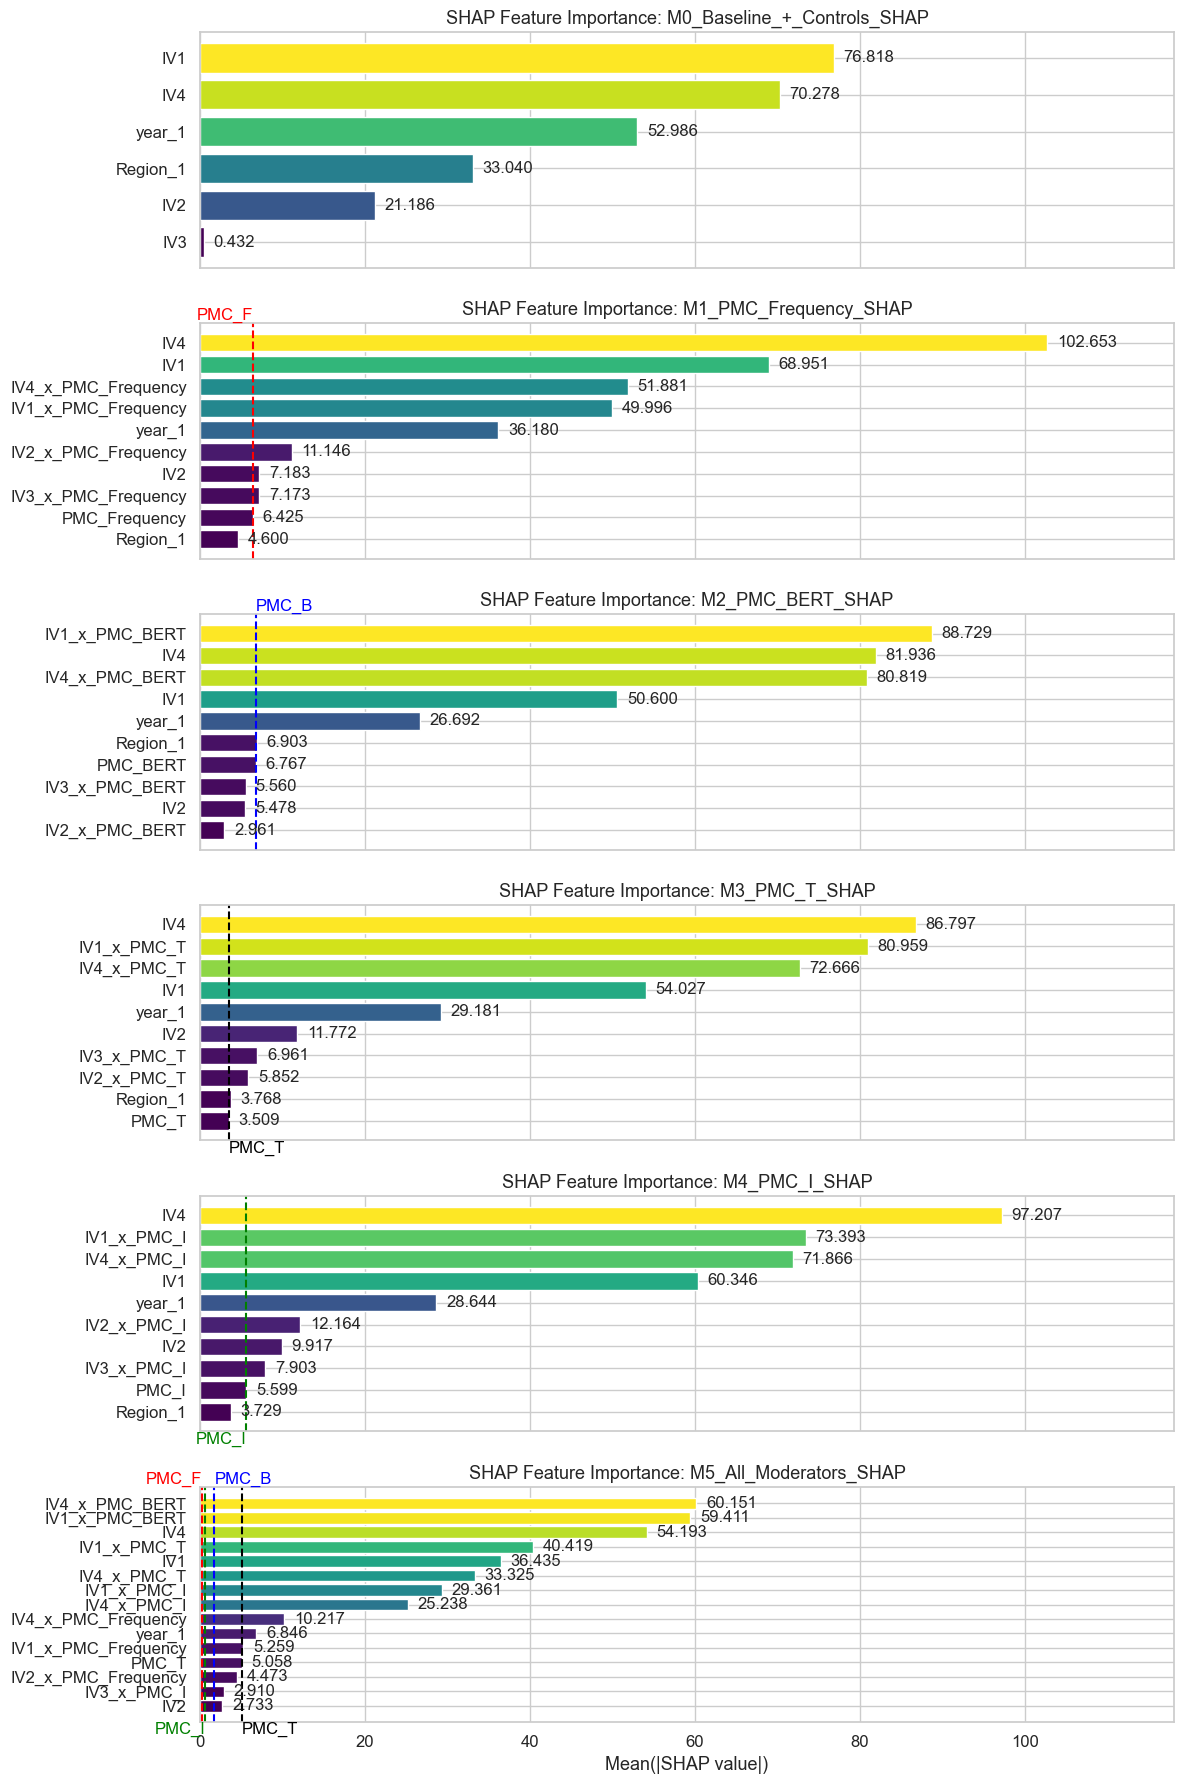

✅ E组图形绘制完成，读取自 shap_outputs/shap_feature_comparison_all_models.csv


In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

# ==================== ✅ 从 CSV 文件读取 shap 数据框（加 e 后缀） ====================
shap_df_all_e = pd.read_csv("shap_outputs/shap_feature_comparison_all_models.csv")

# ==================== ✅ 可视化设置 ====================
top_n = 15
xmax = shap_df_all_e.set_index('Feature').max().max() * 1.15
n_models = shap_df_all_e.shape[1] - 1  # 除去 Feature 列

fig, axes = plt.subplots(n_models, 1, figsize=(12, 3 * n_models), sharex=True)
if n_models == 1:
    axes = [axes]

# 设定 PMC 特征样式（可扩展）
pmc_features = {
    'PMC_Frequency': {'color': 'red', 'vpos': 'top', 'align': 'right', 'label': 'PMC_F'},
    'PMC_BERT':      {'color': 'blue', 'vpos': 'top', 'align': 'left',  'label': 'PMC_B'},
    'PMC_I':         {'color': 'green','vpos': 'bottom','align': 'right','label': 'PMC_I'},
    'PMC_T':         {'color': 'black','vpos': 'bottom','align': 'left','label': 'PMC_T'}
}

# 按模型绘图
for ax, model_col in zip(axes, shap_df_all_e.columns[1:]):
    shap_series_e = shap_df_all_e[["Feature", model_col]].set_index("Feature")[model_col]
    shap_top_e = shap_series_e[shap_series_e > 0].sort_values(ascending=False).head(top_n)

    if shap_top_e.empty:
        ax.text(0.5, 0.5, 'No significant SHAP values', ha='center', va='center', fontsize=14)
        ax.set_title(f"{model_col} (No data)", fontsize=14)
        ax.set_xlim(0, xmax)
        ax.set_yticks([])
        continue

    norm = plt.Normalize(shap_top_e.min(), shap_top_e.max())
    colors = cm.viridis(norm(shap_top_e.values[::-1]))
    bars = ax.barh(shap_top_e.index[::-1], shap_top_e.values[::-1], color=colors)

    for bar in bars:
        width = bar.get_width()
        ax.text(width + xmax * 0.01, bar.get_y() + bar.get_height() / 2,
                f"{width:.3f}", va='center', ha='left', fontsize=12)

    ax.set_title(f"SHAP Feature Importance: {model_col}", fontsize=13)
    ax.set_xlim(0, xmax)
    ax.tick_params(axis='both', labelsize=12)

    for feat, style in pmc_features.items():
        if feat in shap_series_e.index and shap_series_e[feat] > 0:
            val = shap_series_e[feat]
            ax.axvline(val, color=style['color'], linestyle='--', linewidth=1.5)
            y = ax.get_ylim()[1] if style['vpos'] == 'top' else ax.get_ylim()[0]
            va = 'bottom' if style['vpos'] == 'top' else 'top'
            ax.text(val, y, style['label'], rotation=0,
                    color=style['color'], va=va, ha=style['align'], fontsize=12)

plt.xlabel("Mean(|SHAP value|)", fontsize=13)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

print("✅ E组图形绘制完成，读取自 shap_outputs/shap_feature_comparison_all_models.csv")

## F组code  waterfall chart

In [23]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import os

# 创建输出目录
output_dir = "shap_waterfall_outputs"
os.makedirs(output_dir, exist_ok=True)

# Step 1: 找到 y 中最接近中位数的样本
if not isinstance(y, pd.Series):
    y = pd.Series(y)

median_y = y.median()
sample_idx = (y - median_y).abs().idxmin()
true_value = y.loc[sample_idx]
print(f"中位数 y ≈ {median_y:.3f}")
print(f"选定样本索引为: {sample_idx}，真实值: {true_value:.3f}")

# Step 2: 遍历所有模型绘制 waterfall 图
for model_name, (model, X) in model_objects.items():
    try:
        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)

        # 找到该样本的特征向量位置（行号）
        sample_pos = X.index.get_loc(sample_idx)
        sample_features = X.iloc[sample_pos]
        predicted_value = model.predict(X.iloc[[sample_pos]])[0]

        print(f"\n[{model_name}] 预测值: {predicted_value:.3f} | 真实值: {true_value:.3f}")

        # Step 3: 绘制 SHAP waterfall 图
        plt.figure(figsize=(8, 6))
        shap.plots.waterfall(shap_values[sample_pos], max_display=10, show=False)
        plt.suptitle(
            f"{model_name}\nPredicted: {predicted_value:.3f} | Actual: {true_value:.3f}",
            x=0.02, y=1.05, ha='left', fontsize=13
        )
        plt.tight_layout()

        # Step 4: 保存图像
        safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")
        filename = os.path.join(output_dir, f"shap_waterfall_{safe_name}_sample{sample_idx}.png")
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"图像已保存至：{filename}")

        plt.close()
    except Exception as e:
        print(f"错误在模型 {model_name} 中：{e}")


中位数 y ≈ -1.140
选定样本索引为: 0，真实值: -1.140

[M0 (Baseline + Controls)] 预测值: 230.972 | 真实值: -1.140
图像已保存至：shap_waterfall_outputs\shap_waterfall_M0_Baseline_+_Controls_sample0.png

[M1 (PMC_Frequency)] 预测值: 249.160 | 真实值: -1.140
图像已保存至：shap_waterfall_outputs\shap_waterfall_M1_PMC_Frequency_sample0.png

[M2 (PMC_BERT)] 预测值: 135.047 | 真实值: -1.140
图像已保存至：shap_waterfall_outputs\shap_waterfall_M2_PMC_BERT_sample0.png

[M3 (PMC_T)] 预测值: 171.678 | 真实值: -1.140
图像已保存至：shap_waterfall_outputs\shap_waterfall_M3_PMC_T_sample0.png

[M4 (PMC_I)] 预测值: 172.090 | 真实值: -1.140
图像已保存至：shap_waterfall_outputs\shap_waterfall_M4_PMC_I_sample0.png

[M5 (All Moderators)] 预测值: 137.335 | 真实值: -1.140
图像已保存至：shap_waterfall_outputs\shap_waterfall_M5_All_Moderators_sample0.png


## G组code 所有图打包

In [24]:
import shap
import matplotlib.pyplot as plt
import os
import zipfile
import re

# 输出目录，存放图像文件
output_dir = "shap_plots_output"
os.makedirs(output_dir, exist_ok=True)

# 文件路径列表，用于后续打包
file_paths = []

# 遍历模型生成多种 SHAP 图
for model_name, (model, X_model) in model_objects.items():
    print(f"正在处理: {model_name}")
    explainer = shap.Explainer(model, X_model)
    shap_values = explainer(X_model)

    # 安全处理 model_name 用于文件名
    safe_name = re.sub(r'[^\w\s]', '_', model_name)  # 替换所有非字母数字字符

    # BEESWARM
    beeswarm_file = os.path.join(output_dir, f"{safe_name}_beeswarm.png")
    file_paths.append(beeswarm_file)
    plt.figure()
    shap.plots.beeswarm(shap_values, max_display=10, show=False)
    plt.title(f"{model_name} — Beeswarm")
    plt.tight_layout()
    plt.savefig(beeswarm_file, dpi=300)
    plt.close()

    # SCATTER（针对 PMC_BERT）
    scatter_file = os.path.join(output_dir, f"{safe_name}_scatter_PMC_BERT.png")
    file_paths.append(scatter_file)
    plt.figure()
    if "PMC_BERT" in shap_values.feature_names:
        shap.plots.scatter(shap_values[:, "PMC_BERT"], show=False)
        plt.title(f"{model_name} — Scatter: PMC_BERT")
    else:
        plt.text(0.5, 0.5, "'PMC_BERT' not found", ha='center', va='center')
        plt.title(f"{model_name} — Scatter: PMC_BERT")
    plt.tight_layout()
    plt.savefig(scatter_file, dpi=300)
    plt.close()

    # DEPENDENCE（PMC_BERT x IV1）
    dependence_file = os.path.join(output_dir, f"{safe_name}_dependence_PMC_BERT_x_IV1.png")
    file_paths.append(dependence_file)
    plt.figure()
    if "PMC_BERT" in X_model.columns and "IV1" in X_model.columns:
        shap.dependence_plot("PMC_BERT", shap_values.values, features=X_model, interaction_index="IV1", show=False)
        plt.title(f"{model_name} — Dependence: PMC_BERT x IV1")
    else:
        plt.text(0.5, 0.5, "'PMC_BERT' or 'IV1' not found", ha='center', va='center')
        plt.title(f"{model_name} — Dependence: PMC_BERT x IV1")
    plt.tight_layout()
    plt.savefig(dependence_file, dpi=300)
    plt.close()

    # HEATMAP（SHAP summary_plot）
    heatmap_file = os.path.join(output_dir, f"{safe_name}_heatmap.png")
    file_paths.append(heatmap_file)
    plt.figure()
    shap.summary_plot(shap_values.values, X_model, show=False)
    plt.title(f"{model_name} — SHAP Heatmap")
    plt.tight_layout()
    plt.savefig(heatmap_file, dpi=300)
    plt.close()

    # BAR（特征重要性）
    bar_file = os.path.join(output_dir, f"{safe_name}_bar.png")
    file_paths.append(bar_file)
    plt.figure()
    shap.plots.bar(shap_values, max_display=10, show=False)
    plt.title(f"{model_name} — Bar Summary")
    plt.tight_layout()
    plt.savefig(bar_file, dpi=300)
    plt.close()

    # WATERFALL（第一个样本）
    waterfall_file = os.path.join(output_dir, f"{safe_name}_waterfall_sample0.png")
    file_paths.append(waterfall_file)
    plt.figure()
    shap.plots.waterfall(shap_values[0], show=False)
    plt.title(f"{model_name} — Waterfall (Sample 0)")
    plt.tight_layout()
    plt.savefig(waterfall_file, dpi=300)
    plt.close()

# Step: 打包所有图像文件为 ZIP
zip_file_path = "shap_plots_output.zip"
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for file in file_paths:
        zipf.write(file, os.path.relpath(file, output_dir))

print(f"\n✅ 所有 SHAP 图像已保存至文件夹: {output_dir}")
print(f"✅ 图像已打包为 ZIP 文件: {zip_file_path}")


正在处理: M0 (Baseline + Controls)


C:\Users\Eric\AppData\Local\Temp\ipykernel_5316\909953148.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_model, show=False)


正在处理: M1 (PMC_Frequency)


C:\Users\Eric\AppData\Local\Temp\ipykernel_5316\909953148.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_model, show=False)


正在处理: M2 (PMC_BERT)


C:\Users\Eric\AppData\Local\Temp\ipykernel_5316\909953148.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_model, show=False)


正在处理: M3 (PMC_T)


C:\Users\Eric\AppData\Local\Temp\ipykernel_5316\909953148.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_model, show=False)


正在处理: M4 (PMC_I)


C:\Users\Eric\AppData\Local\Temp\ipykernel_5316\909953148.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_model, show=False)


正在处理: M5 (All Moderators)


C:\Users\Eric\AppData\Local\Temp\ipykernel_5316\909953148.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_model, show=False)



✅ 所有 SHAP 图像已保存至文件夹: shap_plots_output
✅ 图像已打包为 ZIP 文件: shap_plots_output.zip


## <b>H组code Robustness test

 新增功能：使用 C组模型评估结果中的 M0 作为 benchmark
读取 C组模型评估结果.csv

提取 M0 的：

RMSE

MSE

R²

在 plot_bootstrap_results 中进行如下经验 P 值计算：

RMSE/MSE：判断是否小于 baseline（更好）

R²/Explained Variance：判断是否大于 baseline（更好）

为了评估模型 M5 的稳健性，我们基于 bootstrap 方法对其预测性能（包括 MSE、RMSE、R² 和 Explained Variance）进行了重复抽样分布模拟（n = 1000）。随后，我们将 M5 的 bootstrap 分布与 baseline 模型 M0（仅包含控制变量与自变量）所得的性能指标进行经验比较。具体而言，对于 RMSE 和 MSE，P 值表示 M5 的 bootstrap 结果中有多少比例大于或等于 M0 的基准值；对于 R² 和 Explained Variance，P 值表示其中有多少比例小于或等于 M0 的基准值。该经验 P 值衡量了 M5 在不同抽样下是否稳定优于 baseline，从而间接反映模型在当前数据中的相对优势及稳健性。，P 值在图中以三种显著性标记表示：p < 0.05（*）、< 0.01（**）、< 0.005（ *** ）。

虽然 M5 模型在误差指标（MSE, RMSE）与整体拟合度（R²）上显著优于 baseline，但在 explained variance 指标上未表现出统计显著。这可能源于模型输出值的方差未能充分覆盖目标变量的整体波动性，提示尽管模型预测误差较小，但其在解释因变量动态变化方面的能力尚有限。

✅ Model metadata loaded: search_seed = 42 , eval_seed = 42
Bootstrap results saved to Robustness_test\bootstrap_results.csv


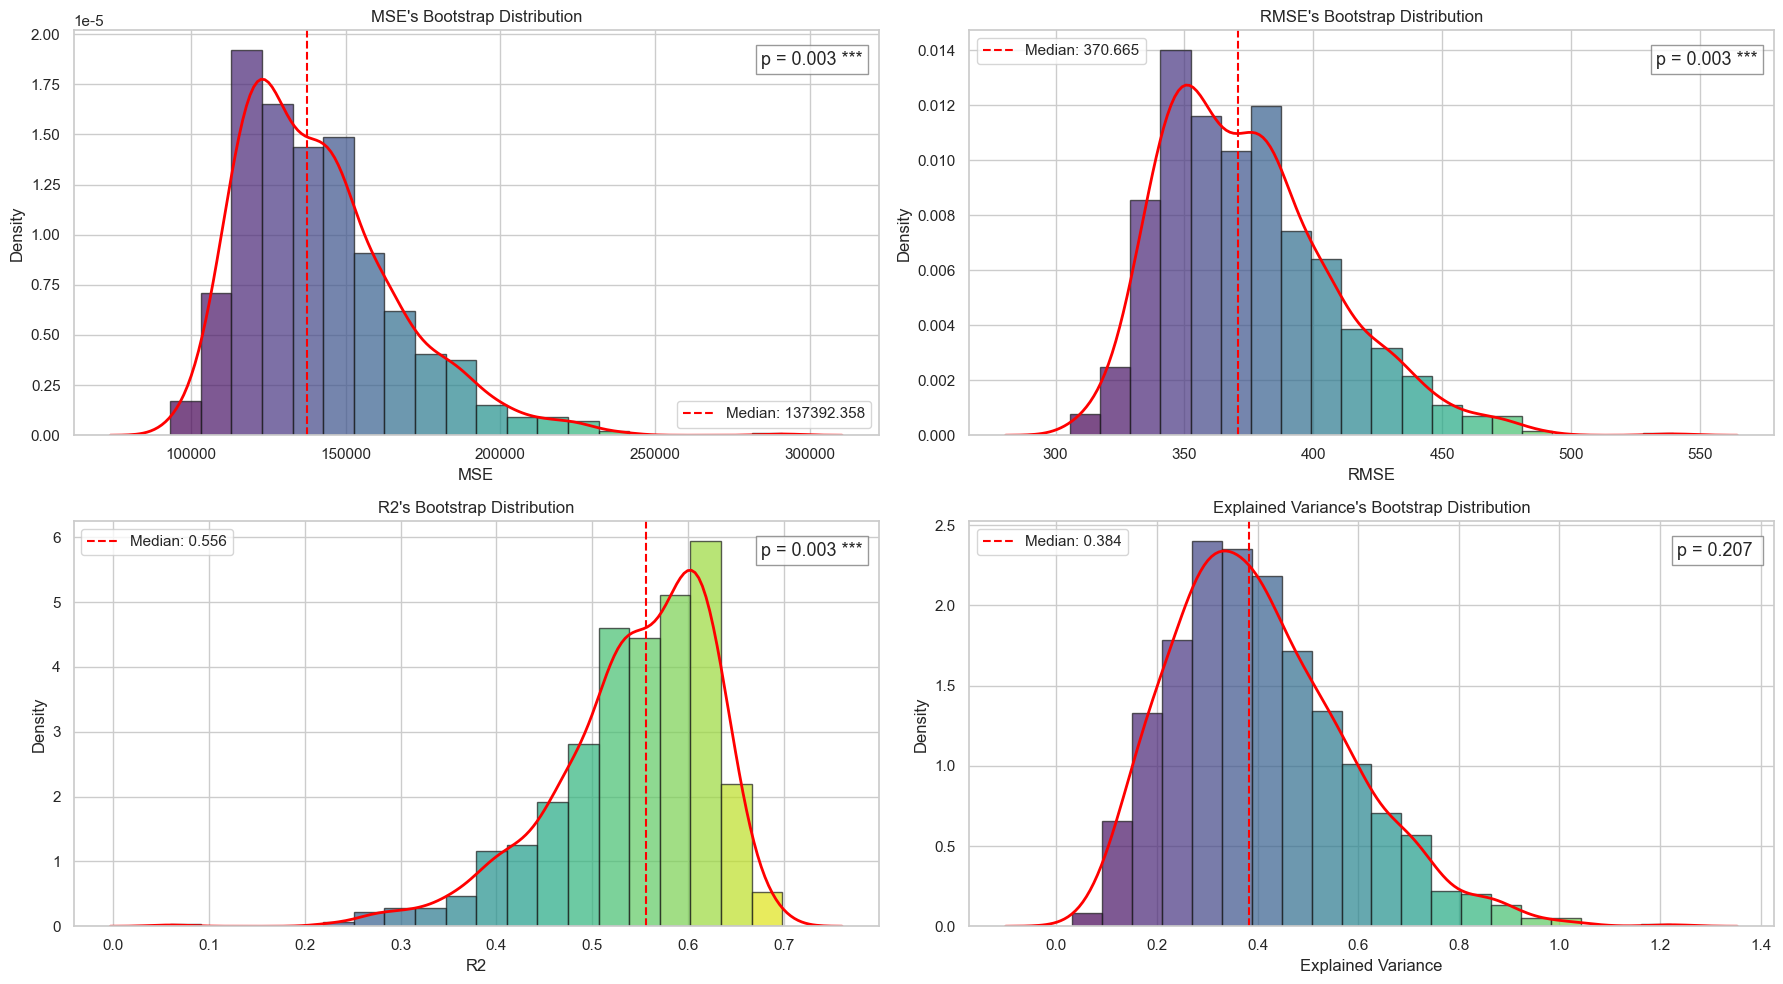

K-Fold results saved to kfold_results.csv


In [25]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
import os
from sklearn.model_selection import KFold
import scipy.stats as stats

# ========== ✅ 计算 DataFrame 哈希（固定顺序 & 类型） ==========
def hash_df(df):
    df_sorted = df.copy()
    df_sorted = df_sorted.reindex(sorted(df_sorted.columns), axis=1)
    df_sorted = df_sorted.astype(np.float64)
    return pd.util.hash_pandas_object(df_sorted, index=True).values.sum()

# ========== ✅ 读取最佳模型参数（只校验模型来源，跳过 X/y 哈希） ==========
def load_best_model_snapshot(file_path="best_model_m5.json"):
    with open(file_path, "r") as f:
        snapshot = json.load(f)

    params = snapshot["best_params"]
    for k in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]:
        params[k] = int(params[k])
    for k in ["max_features", "ccp_alpha"]:
        params[k] = float(params[k])
    params["random_state"] = int(params["random_state"])

    meta = snapshot["meta"]
    print("✅ Model metadata loaded: search_seed =", meta.get("search_seed"), ", eval_seed =", meta.get("eval_seed"))
    return params

# ========== ✅ KFold 交叉验证 ==========
def k_fold_robustness_test_parallel(X, y, model, n_splits=3, n_jobs=-1, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = []

    for fold_num, (train_idx, valid_idx) in enumerate(kf.split(X), 1):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        mse = mean_squared_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)

        results.append({"Fold": f"Fold {fold_num}", "RMSE": rmse, "MSE": mse, "R²": r2})

    return pd.DataFrame(results)

# ========== ✅ Bootstrap 重抽样 ==========
def bootstrap_resampling_parallel(X, y, model, n_iterations=1000, n_jobs=-1):
    # 转换 y 为 Series（防止进入子进程出错）
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]
    y = np.asarray(y).ravel()  # 确保为 1D

    results = Parallel(n_jobs=n_jobs)(
        delayed(perform_bootstrap_iteration)(X.values, y, model) for _ in range(n_iterations)
    )
    return {
        'MSE': [r[0] for r in results],
        'RMSE': [r[1] for r in results],
        'R2': [r[2] for r in results],
        'Explained Variance': [r[3] for r in results]
    }

def perform_bootstrap_iteration(X, y, model):
    X_df = pd.DataFrame(X)
    X_resampled, y_resampled = resample(X_df, y, random_state=None)
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_df)

    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    explained_variance = np.var(y_pred) / np.var(y)

    return mse, rmse, r2, explained_variance

# ========== ✅ 增强图像：添加 P 值（与 C组 M0 模型对比） ==========
def plot_bootstrap_results(bootstrap_df, output_dir, baseline_metrics):
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes = axes.flatten()
    viridis_cmap = plt.cm.viridis

    for i, metric in enumerate(["MSE", "RMSE", "R2", "Explained Variance"]):
        data = bootstrap_df[metric]
        n, bins, patches = axes[i].hist(data, bins=20, edgecolor='k', alpha=0.7, density=True)

        for j, patch in enumerate(patches):
            plt.setp(patch, 'facecolor', viridis_cmap(j / len(patches)))

        sns.kdeplot(data, ax=axes[i], color='red', lw=2)
        median_val = np.median(data)
        axes[i].axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.3f}')

        baseline_val = baseline_metrics.get(metric, None)
        if baseline_val is not None:
            if metric in ["MSE", "RMSE"]:
                p_val = np.mean(np.array(data) >= baseline_val)
            else:  # R2, Explained Variance
                p_val = np.mean(np.array(data) <= baseline_val)
        else:
            p_val = 1.0

        if p_val < 0.005:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = ''

        axes[i].text(0.98, 0.95, f'p = {p_val:.3f} {sig}',
                     transform=axes[i].transAxes, fontsize=13,
                     ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

        axes[i].set_title(f"{metric}'s Bootstrap Distribution")
        axes[i].set_xlabel(metric)
        axes[i].set_ylabel("Density")
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plot_file = os.path.join(output_dir, "Bootstrap_distribution_rf.png")
    plt.savefig(plot_file)
    plt.show()

# ========== ✅ 保存 CSV ==========
def save_bootstrap_results(bootstrap_results, output_file):
    bootstrap_df = pd.DataFrame(bootstrap_results)
    bootstrap_df.to_csv(output_file, index=False)
    print(f"Bootstrap results saved to {output_file}")

# ========== ✅ 主函数 ==========
def main(X, y, best_params_file="best_model_m5.json", output_dir="Robustness_test", c_group_csv="C组模型评估结果.csv"):
    os.makedirs(output_dir, exist_ok=True)

    best_params = load_best_model_snapshot(file_path=best_params_file)
    model = RandomForestRegressor(**best_params)

    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]  # ✅ 确保 y 是 Series

    # 读取 C组 baseline（M0）结果作为基准
    df_c = pd.read_csv(c_group_csv)
    df_m0 = df_c[df_c['Model'] == 'M0 (Baseline + Controls)'].iloc[0]
    baseline_metrics = {
        'MSE': df_m0['MSE'],
        'RMSE': df_m0['RMSE'],
        'R2': df_m0['R²'],
        'Explained Variance': df_m0['R²']  # 近似处理
    }

    bootstrap_results = bootstrap_resampling_parallel(X, y, model, n_iterations=1000, n_jobs=-1)
    bootstrap_df = pd.DataFrame(bootstrap_results)

    output_file = os.path.join(output_dir, "bootstrap_results.csv")
    save_bootstrap_results(bootstrap_results, output_file)
    plot_bootstrap_results(bootstrap_df, output_dir, baseline_metrics)

    kfold_results = k_fold_robustness_test_parallel(X, y, model, n_splits=5, n_jobs=-1, random_state=42)
    kfold_results.to_csv(os.path.join(output_dir, 'kfold_results.csv'), index=False)
    print("K-Fold results saved to kfold_results.csv")

# Run
y= df_raw["Dep"]
main(X, y)

## <b>I组code sensitivity analysis

### sensitivity analysis (I2)

In [26]:
import json
import pandas as pd
import numpy as np

# === 加载最佳模型参数 ===
def load_best_model_snapshot(file_path="best_model_m5.json"):
    with open(file_path, "r") as f:
        snapshot = json.load(f)

    params = snapshot["best_params"]
    for k in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]:
        params[k] = int(params[k])
    for k in ["max_features", "ccp_alpha"]:
        params[k] = float(params[k])
    params["random_state"] = int(params["random_state"])

    eval_seed = snapshot["meta"].get("eval_seed", 42)
    return params, eval_seed

# === 逐步移除控制变量进行敏感性分析 ===
def evaluate_sensitivity_analysis(df_combined, y, baseline_features, control_features, moderators, rf_params):
    results = []

    # 初始模型（包括所有控制变量）
    df_m5, _ = build_model_features_all_v2(df_combined, baseline_features, moderators, control_features)
    rmse_m5 = evaluate_model(rf_params, df_m5, y)
    mse_m5 = rmse_m5 ** 2
    r2_m5 = 1 - mse_m5 / np.var(y)
    results.append({"Model": "M5 (All Moderators)", "RMSE": rmse_m5, "MSE": mse_m5, "R²": r2_m5})

    # 逐步移除每一个控制变量
    for i in range(len(control_features)):
        control_features_subset = control_features[:i] + control_features[i+1:]
        df_m5_sub, _ = build_model_features_all_v2(df_combined, baseline_features, moderators, control_features_subset)
        rmse_sub = evaluate_model(rf_params, df_m5_sub, y)
        mse_sub = rmse_sub ** 2
        r2_sub = 1 - mse_sub / np.var(y)
        model_name = f"M5 (Control variables removed: {', '.join(control_features[i:i+1])})"
        results.append({"Model": model_name, "RMSE": rmse_sub, "MSE": mse_sub, "R²": r2_sub})

    return pd.DataFrame(results)

# === 设置参数并开始敏感性分析 ===
baseline_features = ["IV1", "IV2", "IV3", "IV4"]
control_features = ["year_1", "Region_1"]
moderators = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

df_raw = df_combined.copy()
y = df_raw["Dep"]

# 获取最佳模型参数和评估种子
best_params, eval_seed = load_best_model_snapshot(file_path="best_model_m5.json")

# 获取 M5 模型的敏感性分析结果
df_sensitivity_results = evaluate_sensitivity_analysis(
    df_combined=df_raw,
    y=y,
    baseline_features=baseline_features,
    control_features=control_features,
    moderators=moderators,
    rf_params=best_params
)

# 输出结果
print("\n========= ✅ M5模型敏感性分析结果（逐步移除控制变量） =========")
print(df_sensitivity_results.to_string(index=False))

# 可选保存为 CSV 文件  
df_sensitivity_results.to_csv("M5模型敏感性分析结果.csv", index=False, encoding="utf-8-sig")
print("📁 M5模型敏感性分析结果已保存为 M5模型敏感性分析结果.csv")



========= ✅ M5模型敏感性分析结果（逐步移除控制变量） =========
                                   Model       RMSE           MSE       R²
                     M5 (All Moderators) 441.351833 194791.440741 0.370446
  M5 (Control variables removed: year_1) 452.698918 204936.310122 0.337659
M5 (Control variables removed: Region_1) 451.313853 203684.193945 0.341706
📁 M5模型敏感性分析结果已保存为 M5模型敏感性分析结果.csv


### I3组 snesitivity analysis M0-5重新找超参数

In [33]:
import optuna
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# ==================== ✅ 评估函数 ====================
def evaluate_model(params, X, y, n_splits=3, random_state=1203):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_list = []
    
    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_list.append(rmse)
    
    return np.mean(rmse_list)

# ==================== ✅ Optuna 调参函数 ====================
def objective(trial, X, y, model_type="M0"):
    n_samples = len(X)
    seed_val = trial.suggest_categorical('seed', [1203, 42, 2023])

    if model_type == "M0":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 
                                                   max(3, int(0.03 * n_samples)), 
                                                   max(15, int(0.15 * n_samples))),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 
                                                  max(3, int(0.02 * n_samples)), 
                                                  max(10, int(0.1 * n_samples))),
            'max_features': trial.suggest_float('max_features', 0.25, 0.75),
            'bootstrap': False,
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
            'n_jobs': 1,
            'warm_start': True
        }
    elif model_type == "M1":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 
                                                   max(3, int(0.03 * n_samples)), max(15, int(0.15 * n_samples))),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 
                                                   max(3, int(0.02 * n_samples)), max(10, int(0.1 * n_samples))),
            'max_features': trial.suggest_float('max_features', 0.25, 0.75),
            'bootstrap': False,
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
            'n_jobs': 1,
            'warm_start': True
        }
    elif model_type == "M2":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 
                                                   max(3, int(0.03 * n_samples)), 
                                                   max(20, int(0.15 * n_samples))),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 
                                                  max(3, int(0.02 * n_samples)), 
                                                  max(15, int(0.1 * n_samples))),
            'max_features': trial.suggest_float('max_features', 0.25, 0.75),
            'bootstrap': False,
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
            'n_jobs': 1,
            'warm_start': True
        }
    elif model_type == "M3":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 
                                                   max(3, int(0.03 * n_samples)), max(20, int(0.15 * n_samples))),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 
                                                  max(3, int(0.02 * n_samples)), max(15, int(0.1 * n_samples))),
            'max_features': trial.suggest_float('max_features', 0.25, 0.75),
            'bootstrap': False,
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
            'n_jobs': 1,
            'warm_start': True
        }
    elif model_type == "M4":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 
                                                   max(3, int(0.03 * n_samples)), max(25, int(0.15 * n_samples))),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 
                                                  max(3, int(0.02 * n_samples)), max(20, int(0.1 * n_samples))),
            'max_features': trial.suggest_float('max_features', 0.25, 0.75),
            'bootstrap': False,
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
            'n_jobs': 1,
            'warm_start': True
        }
    elif model_type == "M5":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 
                                                   max(3, int(0.03 * n_samples)), max(25, int(0.15 * n_samples))),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 
                                                  max(3, int(0.03 * n_samples)), max(20, int(0.1 * n_samples))),
            'max_features': trial.suggest_float('max_features', 0.25, 0.75),
            'bootstrap': False,
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
            'n_jobs': 1,
            'warm_start': True
        }
    
    return evaluate_model(param, X, y, random_state=seed_val)

# ==================== ✅ 进行超参数优化并评估 M0 到 M5 ====================
def run_sensitivity_analysis(df_combined, baseline_features, control_features, moderators):
    # Get the data for modeling
    df_m5, m5_features = build_model_features_all_v2(df_combined, baseline_features, moderators, control_features)
    X = df_m5
    y = df_combined["Dep"]

    # Create a dictionary to store results for each model (M0 to M5)
    results_i3 = []

    # Iterate through models M0 to M5
    for model_type in ["M0", "M1", "M2", "M3", "M4", "M5"]:
        # Optimize hyperparameters for each model
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X, y, model_type), n_trials=100)
        
        best_rmse = study.best_value
        best_mse = best_rmse ** 2
        best_r2 = 1 - best_mse / np.var(y)
        
        best_params = study.best_trial.params
        best_seed = best_params.pop("seed")
        best_params['random_state'] = best_seed
        
        # Store results
        results_i3.append({
            "Model": model_type,
            "RMSE": best_rmse,
            "MSE": best_mse,
            "R²": best_r2,
            "Best_Params": best_params
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results_i3)
    
    # Save to CSV
    results_df.to_csv("i3_sensitivity_results.csv", index=False)
    print(f"Results saved as i3_sensitivity_results.csv")
    
    return results_df

# ==================== ✅ 运行敏感性分析 ====================
baseline_features = ["IV1", "IV2", "IV3", "IV4"]
control_features = ["year_1", "Region_1"]
moderators = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

df_raw = df_combined.copy()

# Run sensitivity analysis for M0-M5
df_sensitivity_results_i3 = run_sensitivity_analysis(df_combined=df_raw, 
                                                    baseline_features=baseline_features,
                                                    control_features=control_features,
                                                    moderators=moderators)

# Display the results
print(df_sensitivity_results_i3)

[I 2025-10-05 08:15:31,158] A new study created in memory with name: no-name-acc6c7d6-ed6e-4530-9257-727694e3cdb5
[I 2025-10-05 08:15:31,363] Trial 0 finished with value: 419.9553733175385 and parameters: {'seed': 2023, 'n_estimators': 151, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.35007502820599357, 'ccp_alpha': 0.03594208555278542}. Best is trial 0 with value: 419.9553733175385.
[I 2025-10-05 08:15:31,468] Trial 1 finished with value: 492.4805260241694 and parameters: {'seed': 2023, 'n_estimators': 73, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 0.5850898787796972, 'ccp_alpha': 0.011996652285614147}. Best is trial 0 with value: 419.9553733175385.
[I 2025-10-05 08:15:31,714] Trial 2 finished with value: 421.97339167287237 and parameters: {'seed': 42, 'n_estimators': 184, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 0.5533268077039697, 'ccp_alpha': 0.003431161495295606}. Best is

Results saved as i3_sensitivity_results.csv
  Model        RMSE            MSE        R²  \
0    M0  369.782176  136738.857884  0.558069   
1    M1  368.478257  135776.225537  0.561180   
2    M2  366.814490  134552.870310  0.565134   
3    M3  371.410264  137945.584062  0.554169   
4    M4  387.287171  149991.353050  0.515237   
5    M5  386.101755  149074.565203  0.518200   

                                         Best_Params  
0  {'n_estimators': 152, 'max_depth': 3, 'min_sam...  
1  {'n_estimators': 88, 'max_depth': 6, 'min_samp...  
2  {'n_estimators': 64, 'max_depth': 6, 'min_samp...  
3  {'n_estimators': 134, 'max_depth': 6, 'min_sam...  
4  {'n_estimators': 103, 'max_depth': 3, 'min_sam...  
5  {'n_estimators': 95, 'max_depth': 5, 'min_samp...  


#### J组 城市层级比较
把 “PMC 指标 + 市场条件” 的发现进一步放到城市层级的比较语境里

In [40]:
# ==================== 📂 J组代码：PMC × 城市层级交互 + 四阶交互可视化 ====================
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import os

# ========== Step 0. 读取 best_params ==========
def load_best_model_snapshot(file_path="best_model_m5.json"):
    with open(file_path, "r") as f:
        snapshot = json.load(f)
    params = snapshot["best_params"]

    # 转换参数类型
    for k in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]:
        params[k] = int(params[k])
    for k in ["max_features", "ccp_alpha"]:
        params[k] = float(params[k])
    params["random_state"] = int(params["random_state"])
    print("✅ best_params 已从 JSON 文件加载成功")
    return params

# ========== Step 1. 构造城市层级变量（Dummy） ==========
def add_region_dummies(df, region_col="Region_1"):
    """
    将 Region_1 转换为一线/二线/三线城市的哑变量
    """
    df_region = pd.get_dummies(df[region_col], prefix="Region", drop_first=True)
    return pd.concat([df, df_region], axis=1), list(df_region.columns)

# ========== Step 2. 构造特征 ==========
def build_features_with_region_interactions(df, baseline, moderators, region_dummies):
    df_temp = df.copy()
    features = list(baseline) + moderators + region_dummies

    # PMC × Region 交互项
    for mod in moderators:
        for reg in region_dummies:
            inter_col = f"{mod}_x_{reg}"
            df_temp[inter_col] = df_temp[mod] * df_temp[reg]
            features.append(inter_col)

    # IV × PMC 交互项
    for mod in moderators:
        for iv in baseline:
            inter_col = f"{iv}_x_{mod}"
            df_temp[inter_col] = df_temp[iv] * df_temp[mod]
            features.append(inter_col)

    # 新增：PMC 四阶整体交互
    if all(m in df_temp.columns for m in moderators):
        inter_col = "PMC_AllInteraction"
        df_temp[inter_col] = (
            df_temp["PMC_Frequency"] *
            df_temp["PMC_BERT"] *
            df_temp["PMC_T"] *
            df_temp["PMC_I"]
        )
        features.append(inter_col)

        # IV1 × PMC_All
        iv1_inter = "IV1_x_PMC_ALL"
        df_temp[iv1_inter] = df_temp["IV1"] * df_temp[inter_col]
        features.append(iv1_inter)

        # IV4 × PMC_All
        iv4_inter = "IV4_x_PMC_ALL"
        df_temp[iv4_inter] = df_temp["IV4"] * df_temp[inter_col]
        features.append(iv4_inter)

    return df_temp[features], features

# ========== Step 3. 评估函数 ==========
def evaluate_model(params, X, y, n_splits=3, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_list = []
    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_list.append(rmse)
    return np.mean(rmse_list)

# ========== Step 4. SHAP 分层可视化 + CSV ==========
def shap_by_region(model, X, df, region_col="Region_1", out_dir="./shap_plots_output/J_code_plots"):
    os.makedirs(out_dir, exist_ok=True)

    # 计算 SHAP
    explainer = shap.Explainer(model, X.astype(float))
    shap_values = explainer(X.astype(float))

    # 保存 SHAP 值到 DataFrame
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_df[region_col] = df[region_col].values  # 附加城市层级
    shap_df["Dep"] = df["Dep"].values           # 附加因变量

    # === 保存为 CSV 文件 ===
    csv_path = f"{out_dir}/Jgroup_shap_values.csv"
    shap_df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"✅ SHAP 值已保存为 CSV: {os.path.abspath(csv_path)}")

    # === 绘制关键交互项 3×3 箱线图 ===
    plot_key_interactions(shap_df, region_col=region_col, out_dir=out_dir)

    return shap_df

# ========== Step 5. 绘制关键交互项 3×3 箱线图 ==========

# ========== Step 5. 绘制关键交互项 3×3 箱线图 ==========
def plot_key_interactions(shap_df, region_col="Region_1", out_dir="./shap_plots_output/J_code_plots"):
    key_features = [
        "IV1_x_PMC_BERT", "IV1_x_PMC_T", "IV4_x_PMC_BERT",
        "IV4_x_PMC_T", "IV4_x_PMC_I", "IV2_x_PMC_Frequency",
        "IV2_x_PMC_I", "IV1_x_PMC_ALL", "IV4_x_PMC_ALL"
    ]

    # 美观变量名映射
    pretty_names = {
        "IV1_x_PMC_BERT": "HousePrice(IV_1) × PMC_B",
        "IV1_x_PMC_T": "HousePrice(IV_1) × PMC_T",
        "IV4_x_PMC_BERT": "Capital(IV_4) × PMC_B",
        "IV4_x_PMC_T": "Capital(IV_4) × PMC_T",
        "IV4_x_PMC_I": "Capital(IV_4) × PMC_I",
        "IV2_x_PMC_Frequency": "Absorption(IV_2) × PMC_F",
        "IV2_x_PMC_I": "Absorption(IV_2) × PMC_I",
        "IV1_x_PMC_ALL": "HousePrice(IV_1) × [PMC_T, PMC_I, PMC_F, PMC_B]",
        "IV4_x_PMC_ALL": "Capital(IV_4) × [PMC_T, PMC_I, PMC_F, PMC_B]"
    }

    n_cols = 3
    n_rows = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    for i, feat in enumerate(key_features):
        ax = axes[i]

        # 使用 viridis 色卡，缩小箱体宽度
        sns.boxplot(
            x=region_col, y=feat, data=shap_df,
            palette="viridis", width=0.3, ax=ax
        )
        ax.axhline(0, color="black", linestyle="--")
        ax.set_title(pretty_names.get(feat, feat), fontsize=11)
        ax.set_xlabel("City Tier")
        ax.set_ylabel("SHAP value")

        # 计算并标注均值
        means = shap_df.groupby(region_col)[feat].mean()
        for j, (tier, mean_val) in enumerate(means.items()):
            ax.text(
                j, mean_val, f"Mean = {mean_val:.3f}",
                color="brown", fontsize=9, ha="center", va="bottom", fontweight="bold"
            )

    plt.tight_layout()
    plt.savefig(f"{out_dir}/Jgroup_KeyInteractions.png", dpi=300)
    plt.close()
    print(f"✅ 关键交互 SHAP 箱型图 (3×3, viridis, 含均值标注, 美观缩写) 已保存至 {os.path.abspath(out_dir)}")



# ========== Step 6. 主流程 ==========
def main_Jgroup(df_combined, baseline, moderators, json_file="best_model_m5.json"):
    # 1. 读取 best_params
    best_params = load_best_model_snapshot(json_file)

    # 2. 增加 Region dummy
    df_with_region, region_dummies = add_region_dummies(df_combined, region_col="Region_1")

    # 3. 构造特征
    X, features = build_features_with_region_interactions(
        df_with_region, baseline, moderators, region_dummies
    )
    X = X.apply(pd.to_numeric, errors="coerce")
    y = df_with_region["Dep"]

    # 4. 训练模型
    model = RandomForestRegressor(**best_params)
    model.fit(X, y)

    # 5. 模型性能
    rmse = evaluate_model(best_params, X, y)
    print(f"📊 J组模型 (含 PMC×Region + PMC 四阶交互) RMSE = {rmse:.3f}")

    # 6. SHAP 分层可视化 + 关键交互出图
    shap_df = shap_by_region(model, X, df_with_region, region_col="Region_1")

    return model, X, y, shap_df

# ==================== 执行入口 ====================
baseline_features = ["IV1", "IV2", "IV3", "IV4"]
moderators = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

# 假设 df_combined 已经存在
model_J, X_J, y_J, shap_J = main_Jgroup(df_combined, baseline_features, moderators)


✅ best_params 已从 JSON 文件加载成功
📊 J组模型 (含 PMC×Region + PMC 四阶交互) RMSE = 392.446
✅ SHAP 值已保存为 CSV: C:\bgy\C-documents\碧桂园\集团运营管理工作\专项工作\2023年保交楼\23-12-15\刘磊-监控资金政策分析\code\shap_plots_output\J_code_plots\Jgroup_shap_values.csv


C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\2514056664.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\2514056664.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\2514056664.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\2514056664.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

✅ 关键交互 SHAP 箱型图 (3×3, viridis, 含均值标注, 美观缩写) 已保存至 C:\bgy\C-documents\碧桂园\集团运营管理工作\专项工作\2023年保交楼\23-12-15\刘磊-监控资金政策分析\code\shap_plots_output\J_code_plots


## K组代码
1\. 构造“四杠杆一致性指标”的计算函数（0–10 标准化，要求三杠杆都有非零覆盖）；

2\. 生成消融实验（A/B 两层）结果骨架 CSV，数值留 placeholder（–0.0## / +0.### 等）便于后续填数；

3\. 从 J 组导出的 Jgroup_shap_values.csv 里取关键交互，画 3×3 viridis 箱线图（箱体窄、标注均值 Mean = ##.###）；

4\. 自动吐出 Appendix #8 的 Markdown 草稿（A8.1–A8.4 小节），把表格与图的文件路径都写好。

5\. 输出目录：./ablation_design/（CSV + Markdown）、./ablation_design/fig/（图）

In [46]:
# ==================== 📂 K组（正式版）：含 CV1/CV2 的基线 + 固定折分 + Δ性能 + ΔSHAP + 热力图 ====================
import os
import json
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# -------------------- 全局配置 --------------------
SEED = 42
N_SPLITS = 5
JSON_PATH = "best_model_m5.json"

OUT_DIR = "./ablation_design"
SHAP_DIR = os.path.join(OUT_DIR, "shap_deltas")
FIG_DIR  = os.path.join(OUT_DIR, "fig")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(SHAP_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# -------------------- 工具函数 --------------------
def load_best_params(json_path=JSON_PATH):
    with open(json_path, "r") as f:
        best = json.load(f)["best_params"]
    # 强制类型
    for k in ["n_estimators","max_depth","min_samples_split","min_samples_leaf"]:
        best[k] = int(best[k])
    for k in ["max_features","ccp_alpha"]:
        best[k] = float(best[k])
    best["random_state"] = SEED
    return best

def ensure_numeric(df):
    return df.apply(pd.to_numeric, errors="coerce")

def generate_fixed_splits(X, n_splits=N_SPLITS, seed=SEED):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return [(tr, va) for tr, va in kf.split(X)]

def eval_fixed_splits(model, X, y, splits):
    rmse_list, r2_list = [], []
    for tr, va in splits:
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y.iloc[tr], y.iloc[va]
        model.fit(Xtr, ytr)
        pred = model.predict(Xva)
        rmse_list.append(np.sqrt(mean_squared_error(yva, pred)))
        r2_list.append(r2_score(yva, pred))
    return float(np.mean(rmse_list)), float(np.mean(r2_list))

def compute_shap_summary(model, X, tag, save_dir=SHAP_DIR):
    # 强制转换为 float，防止 object dtype 报错
    X_num = X.copy()
    X_num = X_num.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(float)

    explainer = shap.Explainer(model, X_num)
    sv = explainer(X_num)

    shap_df = pd.DataFrame(sv.values, columns=X_num.columns)
    shap_mean = shap_df.abs().mean().sort_values(ascending=False)
    shap_mean.to_csv(os.path.join(save_dir, f"{tag}_shap_mean.csv"), encoding="utf-8-sig")
    return shap_mean


def compare_shap(base_shap, var_shap, focus_feats):
    """
    返回：只针对 focus_feats（PMC 特征）的 ΔSHAP 均值和 ΔRank。
    """
    base = base_shap.copy()
    var  = var_shap.copy()
    df = pd.concat([base.rename("Base"), var.rename("Variant")], axis=1)
    df["ΔMean"] = df["Variant"] - df["Base"]
    df["Rank_Base"] = df["Base"].rank(ascending=False, method="dense")
    df["Rank_Variant"] = df["Variant"].rank(ascending=False, method="dense")
    df["ΔRank"] = df["Rank_Variant"] - df["Rank_Base"]
    # 只留关心的政策特征
    df = df.loc[[f for f in focus_feats if f in df.index]].copy()
    return df.sort_values("Rank_Base")

def heatmap_shap_delta(delta_table, out_path):
    """
    delta_table: 行=PMC特征，列=Variant，值=ΔMean 或 ΔMean%
    """
    # 强制所有数据为数值
    delta_table = delta_table.apply(pd.to_numeric, errors="coerce")
    delta_table = delta_table.fillna(0.0).astype(float)

    plt.figure(figsize=(1.6*len(delta_table.columns)+3, 0.6*len(delta_table.index)+2))
    sns.heatmap(delta_table, annot=True, fmt=".2f", cmap="viridis", cbar=True)
    plt.title("Δ SHAP (mean |value|) by Variant - Policy Features")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()


# -------------------- 特征构建（与 M5 一致：IV + PMC + CV1(year_1) + CV2(Region_1 dummy)） --------------------
def build_M5_feature_matrix(df_combined,
                            market_cols = ["IV1","IV2","IV3","IV4"],
                            pmc_cols    = ["PMC_Frequency","PMC_BERT","PMC_T","PMC_I"],
                            cv_year     = "year_1",
                            cv_region   = "Region_1"):
    """
    - year_1 作为数值控制；
    - Region_1 作为分类控制 → dummy（drop_first=True）；
    - 返回 X, y, 以及各组列名（便于消融）。
    """
    need_cols = market_cols + pmc_cols + [cv_year, cv_region, "Dep"]
    missing = [c for c in need_cols if c not in df_combined.columns]
    if missing:
        raise ValueError(f"df_combined 缺少必要列: {missing}")

    df = df_combined.copy()
    # 控制：Region_1 → dummy
    region_dum = pd.get_dummies(df[cv_region], prefix=cv_region, drop_first=True)
    X = pd.concat([
        df[market_cols + pmc_cols + [cv_year]].reset_index(drop=True),
        region_dum.reset_index(drop=True)
    ], axis=1)
    X = ensure_numeric(X)
    y = ensure_numeric(df["Dep"])

    # 记录各组列名（controls 为 year_1 + Region dummy）
    controls = [cv_year] + list(region_dum.columns)
    return X, y, market_cols, pmc_cols, controls

# -------------------- 主实验：Block 消融 + Minus-one（IVs），CV 常开 --------------------
def run_Kgroup(df_combined=None, X_J=None, y_J=None,
               keep_controls_fixed=True,
               out_csv=os.path.join(OUT_DIR, "ablation_results_Kgroup.csv"),
               out_heat=os.path.join(FIG_DIR, "K_SHAP_delta_heatmap.png")):
    """
    1) 若 X_J/y_J 不存在，或其不包含 CV1/CV2，则从 df_combined 重建 M5 基线特征集（含 CV）。
    2) 评估 Baseline、去政策块、去市场块、以及 minus-one IVs。
    3) 输出 ΔR²/ΔRMSE，并生成 PMC 特征的 ΔSHAP 均值表与热力图。
    """
    best_params = load_best_params()

    # —— 基线特征集（优先使用 X_J/y_J，但若不含 CV，则重建）——
    if X_J is not None and y_J is not None:
        has_year   = "year_1" in X_J.columns
        has_region = any(c.startswith("Region_1_") for c in X_J.columns) or ("Region_1" in X_J.columns)
        if has_year and has_region:
            # 直接用传入的 X_J/y_J
            X_base = ensure_numeric(X_J.copy())
            y = pd.to_numeric(y_J)
            # 自动识别各组
            avail = set(X_base.columns)
            pmc_cols    = [c for c in ["PMC_Frequency","PMC_BERT","PMC_T","PMC_I"] if c in avail]
            market_cols = [c for c in ["IV1","IV2","IV3","IV4"] if c in avail]
            control_cols= ["year_1"] + [c for c in X_base.columns if c.startswith("Region_1_")]
        else:
            if df_combined is None:
                raise ValueError("X_J 不含 CV1/CV2，请同时提供 df_combined 以便重建含 CV 的基线特征集。")
            X_base, y, market_cols, pmc_cols, control_cols = build_M5_feature_matrix(df_combined)
    else:
        if df_combined is None:
            raise ValueError("请提供 (X_J, y_J) 或 df_combined。")
        X_base, y, market_cols, pmc_cols, control_cols = build_M5_feature_matrix(df_combined)

    # —— 固定折分 —— 
    splits = generate_fixed_splits(X_base)

    # —— Baseline —— 
    X_base = X_base.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(float)
    model = RandomForestRegressor(**best_params)
    base_rmse, base_r2 = eval_fixed_splits(model, X_base, y, splits)
    model.fit(X_base, y)
    base_shap = compute_shap_summary(model, X_base, "M5_baseline")

    results = [{
        "Variant":"M5 (baseline)",
        "R2":base_r2, "RMSE":base_rmse,
        "ΔR2":0.0, "ΔRMSE":0.0,
        "%ΔR2":0.0, "%ΔRMSE":0.0,
        "Top Policy SHAP Shift":"—"
    }]

    # —— Block-wise 消融（CV 常开）——
    # 去政策块：只留 Market + Controls
    keep_rm_policy = market_cols + (control_cols if keep_controls_fixed else [])
    # 去市场块：只留 PMC + Controls
    keep_rm_market = pmc_cols + (control_cols if keep_controls_fixed else [])

    variants = []
    if pmc_cols:
        variants.append(("– Policy block (remove all PMC)", keep_rm_policy, "remove_PMC"))
    if market_cols:
        label = "– Market block (remove IVs)"
        if keep_controls_fixed and control_cols:
            label += " (CVs kept)"
        variants.append((label, keep_rm_market, "remove_market"))

    # 运行两种 block
    for var_name, keep_feats, tag in variants:
        X_sub = X_base[ [c for c in keep_feats if c in X_base.columns] ].copy()
        rmse, r2 = eval_fixed_splits(model, X_sub, y, splits)
        model.fit(X_sub, y)
        shap_sub = compute_shap_summary(model, X_sub, tag)

        # 只比较 PMC 特征的 SHAP 变化
        foc = [f for f in pmc_cols if f in base_shap.index and f in shap_sub.index]
        shap_delta = compare_shap(base_shap, shap_sub, foc)
        shap_delta.to_csv(os.path.join(SHAP_DIR, f"{tag}_shap_delta_policy.csv"), encoding="utf-8-sig")

        results.append({
            "Variant": var_name,
            "R2": r2, "RMSE": rmse,
            "ΔR2": r2 - base_r2,
            "ΔRMSE": rmse - base_rmse,
            "%ΔR2": (r2 - base_r2)/base_r2*100 if base_r2!=0 else np.nan,
            "%ΔRMSE": (rmse - base_rmse)/base_rmse*100 if base_rmse!=0 else np.nan,
            "Top Policy SHAP Shift": f"ΔRank≈{shap_delta['ΔRank'].mean():+.1f}" if len(shap_delta)>0 else "—"
        })

    # —— Minus-one：只对 IVs，CV 常开，不消融 CV —— 
    for drop_iv in market_cols:
        keep_feats = [c for c in market_cols if c != drop_iv] + pmc_cols + (control_cols if keep_controls_fixed else [])
        X_sub = X_base[ [c for c in keep_feats if c in X_base.columns] ].copy()
        rmse, r2 = eval_fixed_splits(model, X_sub, y, splits)
        model.fit(X_sub, y)
        shap_sub = compute_shap_summary(model, X_sub, f"minus_{drop_iv}")

        foc = [f for f in pmc_cols if f in base_shap.index and f in shap_sub.index]
        shap_delta = compare_shap(base_shap, shap_sub, foc)
        shap_delta.to_csv(os.path.join(SHAP_DIR, f"minus_{drop_iv}_shap_delta_policy.csv"), encoding="utf-8-sig")

        results.append({
            "Variant": f"– {drop_iv}",
            "R2": r2, "RMSE": rmse,
            "ΔR2": r2 - base_r2,
            "ΔRMSE": rmse - base_rmse,
            "%ΔR2": (r2 - base_r2)/base_r2*100 if base_r2!=0 else np.nan,
            "%ΔRMSE": (rmse - base_rmse)/base_rmse*100 if base_rmse!=0 else np.nan,
            "Top Policy SHAP Shift": f"ΔRank≈{shap_delta['ΔRank'].mean():+.1f}" if len(shap_delta)>0 else "—"
        })

    # —— 汇总表 —— 
    df_out = pd.DataFrame(results)
    df_out.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"✅ K组消融结果（含 CV 基线）已保存：{os.path.abspath(out_csv)}")

    # —— 生成 SHAP Δ 热力图（行=PMC，列=Variant，值=ΔMean%）——
    #   用 ΔMean% = (Variant-Base)/Base * 100（Base=0 时不显示）
    heat_tbl = {}
    for fname in os.listdir(SHAP_DIR):
        if fname.endswith("_shap_delta_policy.csv"):
            var = fname.replace("_shap_delta_policy.csv", "")
            dt = pd.read_csv(os.path.join(SHAP_DIR, fname), index_col=0)
            col = []
            for idx, row in dt.iterrows():
                base = row.get("Base", np.nan)
                varv = row.get("Variant", np.nan)
                if pd.notna(base) and base != 0:
                    col.append((idx, (varv-base)/base*100.0))
                else:
                    col.append((idx, np.nan))
            heat_tbl[var] = pd.Series({k: v for k, v in col})
    if heat_tbl:
        heat_df = pd.DataFrame(heat_tbl).sort_index()
        heat_df.to_csv(os.path.join(SHAP_DIR, "K_SHAP_delta_policy_pct.csv"), encoding="utf-8-sig")
        heatmap_shap_delta(heat_df, out_heat)
        print(f"✅ SHAP Δ 热力图已保存：{os.path.abspath(out_heat)}")
    else:
        print("ℹ️ 未生成 SHAP Δ 热力图：未找到 delta CSV。")

    return df_out

# ==================== ✅ 用法 ====================
# 情况 A：你在同一会话里已经有 J 组的 X_J, y_J、以及 df_combined
result = run_Kgroup(df_combined=df_combined, X_J=X_J, y_J=y_J, keep_controls_fixed=True)

# 情况 B：只给 df_combined
# result = run_Kgroup(df_combined=df_combined, keep_controls_fixed=True)


✅ K组消融结果（含 CV 基线）已保存：C:\bgy\C-documents\碧桂园\集团运营管理工作\专项工作\2023年保交楼\23-12-15\刘磊-监控资金政策分析\code\ablation_design\ablation_results_Kgroup.csv
✅ SHAP Δ 热力图已保存：C:\bgy\C-documents\碧桂园\集团运营管理工作\专项工作\2023年保交楼\23-12-15\刘磊-监控资金政策分析\code\ablation_design\fig\K_SHAP_delta_heatmap.png
